In [3]:
# !/usr/bin/env python
# coding: utf-8

# In[21]:


#1) Import libraries
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
matplotlib.rcParams['pdf.fonttype'] = 42

matplotlib.rcParams['ps.fonttype'] = 42

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
import Environments
from collections import OrderedDict
from torch.distributions import MultivariateNormal, Categorical, Binomial
from torch.nn import Softmax
#import pandas as pd
import pickle
import copy
# I use the work of Eric Yu to help me build this algorithm. Link: https://github.com/ericyangyu/PPO-for-Beginners
#https://github.com/nikhilbarhate99/PPO-PyTorch/blob/master/PPO.py

#2) Set up Neural Network functions and classes
    
class Model_PPO(nn.Module):
    """
        Class: actor NN
        :param np_inputs: size input of the NN (size state)
        :param nb_outputs: size output of the NN (size action)
    """  
    def __init__(self, np_inputs, nb_outputs, model_type=0, nb_car=1, mean=0, std=1):
        super(Model_PPO, self).__init__()
        self.model_type=model_type
        self.nb_car=nb_car
        self.mean=mean
        self.std=std
        self.layer1 = nn.Linear(np_inputs, 32)
        self.layer2 = nn.Linear(32, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, nb_outputs)
        if(self.model_type==2):
            self.layer4 = nn.Linear(32, nb_outputs)
            #self.layers_d = [nn.Linear(32, nb_outputs) for i in range(self.nb_car)]
            self.return_layer=Softmax(dim=-1)
        if(self.model_type==1):
            self.layer4 = nn.Linear(32, nb_outputs)
            self.return_layer=nn.Tanh()
        else: #self.model_type==0
            pass
        #torch.nn.init.uniform_(self.layer4.weight,0.003, 0.006)
        torch.nn.init.orthogonal_(self.layer4.weight)

    def forward(self, input1):
        """
        Forward NN : compute the NN with respect the current state
        :param input1: state
        :r(eturn: output of the NN, action
        """ 
        if isinstance(input1, np.ndarray):
            input1 = torch.tensor(input1, dtype=torch.float)
        activation1 = F.relu(self.layer1(input1))
        activation2 = F.relu(self.layer2(activation1))
        activation3 = F.relu(self.layer3(activation2))
        if(self.model_type==2):
            output_d = self.layer4(activation3)
            output_d=output_d.reshape(-1,2)
            output_d=self.return_layer(output_d)
            output=torch.flatten(output_d)

        elif(self.model_type==1):
            output = self.layer4(activation3)
            output=torch.add(torch.mul(self.return_layer(output), self.std),self.mean)

        else:
            output = self.layer4(activation3)
        return output
#3) Rollout on the environment:
from collections import deque
class Env_rollout:
    """ 
        Class : iterate on the environment
        :param env: our environment
        :param max_steps: max steps per episode
    """
    def __init__(self, env, nb_cars, max_steps, dt):
        self.env = env
        self.nb_cars=nb_cars
        self.dt=dt
        self.max_steps = max_steps
        self.prev_state, _ = env.reset()
        self.shape_env=2+9+2
        #int(self.prev_state['car'].shape[0]/env.nb_car)+int(self.prev_state['ped'].shape[0]/env.nb_ped)+(self.prev_state['env'].shape[0])
        self.shape_env_d=2+(6*(2*nb_lines-1))+8+2
        #6+5*env.nb_ped#int(self.prev_state['car'].shape[0]/env.nb_car)+int(self.prev_state['ped'].shape[0])+(self.prev_state['env'].shape[0])
        self.batch_obs_cross=[]
        self.batch_obs_wait=[]
        self.batch_acts_choice=[] # changer par shape(-1,2)
        self.batch_acts_cross=[]
        self.batch_acts_wait=[]
        self.batch_log_probs_choice=[]
        self.batch_log_probs_cross=[]
        self.batch_log_probs_wait=[]
        self.batch_rews_choice = []
        self.batch_rews_cross = []
        self.batch_rews_wait = []
        self.return_softmax=Softmax(dim=-1)
    
    def reset(self):
        """
        Reset: reinitilization (lists et environment).
        """
        self.prev_state, _ = env.reset()
        #self.shape_env=2+9+2
        #int(self.prev_state['car'].shape[0]/env.nb_car)+int(self.prev_state['ped'].shape[0]/env.nb_ped)+(self.prev_state['env'].shape[0])
        #self.shape_env_d=2+(6*(self.env.nb_car-1))+8+2
        self.batch_obs_choice=[]
        self.batch_obs_cross=[]
        self.batch_obs_wait=[]
        self.batch_acts_choice=[]
        self.batch_acts_cross=[]
        self.batch_acts_wait=[]
        self.batch_log_probs_choice=[]
        self.batch_log_probs_cross=[]
        self.batch_log_probs_wait=[]
        self.batch_rews_choice = []
        self.batch_rews_cross = []
        self.batch_rews_wait = []
    
    def reward_choice(self, reward_light):
        """
        Reward of the discrete NN
        """
        return reward_light

    def iterations(self, actor_net_cross, actor_net_wait, actor_net_choice, nbr_episodes, choix=False):
        """
        Iterate on the environment.
        :param actor_net: current policy (actor NN)
        :param nbr_episodes: episode number
        :return: Tensors; state batch, action batch
        """
        batch_obs=[]
        batch_acts=[]
        batch_rews_d=[]
        batch_rews_c=[]
        batch_waiting_time=[]
        self.discount_array = [0.7,0.3]
        action_d=np.array([0] *2*self.env.nb_lines* self.env.nb_ped)
        action_d_light=np.array([0] *2*self.env.nb_lines)
        #prev_action_c=np.array([0.]*self.nb_cars)
        for ep in range(nbr_episodes):
            need_new_d=True
            save_batch=False
            state,_ = self.env.reset()
            if(choix):
                self.choix_test()
                state = self.env.get_state()
            prev_state = np.concatenate([i.flatten() for i in list(state.values())])
            nb_ped=state["env"][1]
            for step_ep in range(self.max_steps): 

                if(need_new_d):
                    ep_rews = []
                    episodic_reward = np.array([0.]*2*self.env.nb_lines)
                    action_all_d=np.array([])
                    action_all_d_light=np.array([])
                    for i in range(2*self.env.nb_lines):
                        for j in range(self.env.nb_ped):
                            new_prev_state, exist = self.obs_car_ped_d(prev_state,i,j)
                            parameters_based = torch.squeeze(actor_net_choice(torch.unsqueeze(torch.tensor(new_prev_state),
                                                                                              dim=0).float()))
                            parameters_based=torch.squeeze(parameters_based)
                            parameters_based=parameters_based.reshape(-1,2)
                            action_d2 = torch.argmax(parameters_based,axis=1)#self.return_softmax(parameters_based)
                            action_all_d = np.append(action_all_d, action_d2.detach().numpy())
                        action_all_d_light=np.append(action_all_d_light,action_all_d[i*self.env.nb_ped+self.closest_ped_d(prev_state,i)])
                    #print(2*action_all_d-1)
                action_d=(2*action_all_d-1)
                action_d_light=(2*action_all_d-1)
                need_new_d=False
                action_all_c=np.array([])
                with torch.no_grad():
                    for i in range(2*self.env.nb_lines):
                        action_c_numpy=np.array(self.env.car_b[1,0])
                        for p in range(self.env.nb_ped):
                            new_prev_state, exist =self.obs_car_ped(prev_state,i,p)
                            if(new_prev_state[7]):
                                new_action_c=torch.tensor(max(min((self.env.speed_limit-new_prev_state[0])/self.env.dt,self.env.car_b[1,0]),self.env.car_b[0,0]))
                            else:
                                if(action_d[i*self.env.nb_ped+p]<=0):
                                    new_action_c = torch.squeeze(actor_net_cross(torch.unsqueeze(torch.tensor(new_prev_state), dim=0).float()))
                                else:
                                    new_action_c = torch.squeeze(actor_net_wait(torch.unsqueeze(torch.tensor(new_prev_state), dim=0).float()))
                            if(new_action_c.dim()==0):
                                new_action_c=torch.unsqueeze(new_action_c,dim=0)
                            action_c_numpy=min(action_c_numpy,new_action_c.detach().numpy())
                            action_c_numpy=min(action_c_numpy,(10.0-new_prev_state[0])/(self.dt))
                            #action_c_numpy=action_c_numpy_new*self.discount_array[0]+prev_action_c[i]*self.discount_array[1]
                            #print(action_c_numpy)
                        action_all_c=np.append(action_all_c, action_c_numpy)
                        #prev_action_c=action_all_c
                    action_all=np.append(action_all_c, action_d_light)
                    
                    state, reward, done, trunc, _ = self.env.step(action_all)
                    batch_obs.append(prev_state)
                    batch_acts.append(action_all_c) #2 actions
                    #print(action_all_c)
                    episodic_reward = np.minimum(episodic_reward,self.env.reward_light)
                    ep_rews.append(reward)
                    if(state["env"][1]!=self.env.nb_ped):
                        need_new_d=True
                        save_batch=True
                    prev_state = np.concatenate([i.flatten() for i in list(state.values())])
                    nb_ped=state["env"][1]
                
                if(save_batch or done):
                    for ped in self.env.pedestrian:
                        batch_waiting_time.append(ped.waiting_time)
                    batch_rews_c.append(ep_rews)
                    batch_rews_d.append(episodic_reward)
                    #print(action_d)
                save_batch=False
                
                if done:
                    break
        batch_rews_c_final=[]
        for ep_rews in reversed(batch_rews_c):
            for rew in reversed(ep_rews):
                batch_rews_c_final.insert(0,rew)
        t_batch_obs=torch.tensor(np.array(batch_obs), dtype=torch.float)
        t_batch_acts=torch.tensor(np.array(batch_acts), dtype=torch.float)
        t_batch_rews_c=torch.tensor(batch_rews_c_final, dtype=torch.float)
        t_batch_rews_d=torch.tensor(batch_rews_d, dtype=torch.float)
        t_batch_waiting_time=torch.tensor(batch_waiting_time, dtype=torch.float)
        return t_batch_obs, t_batch_acts, t_batch_rews_c, t_batch_rews_d, t_batch_waiting_time

    
    def iterations_dataset(self, actor_net_cross, actor_net_wait, actor_net_choice, nbr_episodes):
        """
        Iterate on the environment.
        :param actor_net: current policy (actor NN)
        :param nbr_episodes: episode number
        :return: Tensors; state batch, action batch
        """
        batch_obs=[]
        batch_acts=[]
        batch_rews_d=[]
        batch_rews_c=[]
        batch_waiting_time=[]
        self.discount_array = [0.7,0.3]
        action_d=np.array([0] *2*env.nb_lines* self.env.nb_ped)
        action_d_light=np.array([0] *2*self.env.nb_lines)
        #prev_action_c=np.array([0.]*self.nb_cars)
        file = open("test_data_23.pickle",'rb')
        env_dataset = pickle.load(file)
        for ep in range(nbr_episodes):
            need_new_d=True
            save_batch=False
            self.env=env_dataset[ep]
            state = self.env.get_state()#state,_ = self.env.reset()
            prev_state = np.concatenate([i.flatten() for i in list(state.values())])
            nb_ped=state["env"][1]
            for step_ep in range(self.max_steps): 

                if(need_new_d):
                    ep_rews = []
                    episodic_reward = np.array([0.]*2*self.env.nb_lines)
                    action_all_d=np.array([])
                    action_all_d_light=np.array([])
                    for i in range(2*self.env.nb_lines):
                        for j in range(self.env.nb_ped):
                            new_prev_state, exist = self.obs_car_ped_d(prev_state,i,j)
                            parameters_based = torch.squeeze(actor_net_choice(torch.unsqueeze(torch.tensor(new_prev_state),
                                                                                              dim=0).float()))
                            parameters_based=torch.squeeze(parameters_based)
                            parameters_based=parameters_based.reshape(-1,2)
                            action_d2 = torch.argmax(parameters_based,axis=1)#self.return_softmax
                            action_all_d = np.append(action_all_d, action_d2.detach().numpy())
                        action_all_d_light=np.append(action_all_d_light,action_all_d[i*self.env.nb_ped+self.closest_ped_d(prev_state,i)])
                    #print(2*action_all_d-1)
                action_d=(2*action_all_d-1)
                action_d_light=(2*action_all_d-1)
                need_new_d=False
                action_all_c=np.array([])
                with torch.no_grad():
                    for i in range(2*self.env.nb_lines):
                        action_c_numpy=np.array(self.env.car_b[1,0])
                        for p in range(self.env.nb_ped):
                            new_prev_state, exist =self.obs_car_ped(prev_state,i,p)
                            if(new_prev_state[7]): # pedestrian leaves the crosswalk
                                new_action_c=torch.tensor(max(min((self.env.speed_limit-new_prev_state[0])/self.env.dt,self.env.car_b[1,0]),self.env.car_b[0,0]))
                            else:
                                if(action_d[i*self.env.nb_ped+p]<=0):
                                    new_action_c = torch.squeeze(actor_net_cross(torch.unsqueeze(torch.tensor(new_prev_state), dim=0).float()))
                                else:
                                    new_action_c = torch.squeeze(actor_net_wait(torch.unsqueeze(torch.tensor(new_prev_state), dim=0).float()))
                            if(new_action_c.dim()==0):
                                new_action_c=torch.unsqueeze(new_action_c,dim=0)
                            action_c_numpy=min(action_c_numpy,new_action_c.detach().numpy())
                            action_c_numpy=min(action_c_numpy,(10.0-new_prev_state[0])/(self.dt))
                            #action_c_numpy=action_c_numpy_new*self.discount_array[0]+prev_action_c[i]*self.discount_array[1]
                            #print(action_c_numpy)
                        action_all_c=np.append(action_all_c, action_c_numpy)
                        #prev_action_c=action_all_c
                    action_all=np.append(action_all_c, action_d_light)
                    
                    state, reward, done, trunc, _ = self.env.step(action_all)
                    batch_obs.append(prev_state)
                    batch_acts.append(action_all_c) #2 actions
                    #print(action_all_c)
                    episodic_reward = np.minimum(episodic_reward,self.env.reward_light)
                    ep_rews.append(reward)
                    if(state["env"][1]!=nb_ped):
                        need_new_d=True
                        save_batch=True
                    prev_state = np.concatenate([i.flatten() for i in list(state.values())])
                    nb_ped=state["env"][1]
                
                if(save_batch or done):
                    for ped in self.env.pedestrian:
                        batch_waiting_time.append(ped.waiting_time)
                    batch_rews_c.append(ep_rews)
                    batch_rews_d.append(episodic_reward)
                    #print(action_d)
                save_batch=False
                
                if done:
                    break
        batch_rews_c_final=[]
        for ep_rews in reversed(batch_rews_c):
            for rew in reversed(ep_rews):
                batch_rews_c_final.insert(0,rew)
        t_batch_obs=torch.tensor(np.array(batch_obs), dtype=torch.float)
        t_batch_acts=torch.tensor(np.array(batch_acts), dtype=torch.float)
        t_batch_rews_c=torch.tensor(batch_rews_c_final, dtype=torch.float)
        t_batch_rews_d=torch.tensor(batch_rews_d, dtype=torch.float)
        t_batch_waiting_time=torch.tensor(batch_waiting_time, dtype=torch.float)
        return t_batch_obs, t_batch_acts, t_batch_rews_c, t_batch_rews_d, t_batch_waiting_time

    def iterations_rand(self, actor_net_cross, actor_net_wait, actor_net_choice, cov_mat, cov_mat_d, batch_size, random_rate=0.05):
        """
        Iterate on the environment.
        :param actor_net: current policy (actor NN)
        :param cov_mat: covariance matrix used for exploration
        :param batch_size: batch size
        :return: Tensors; state batch, action batch, log_proba batch
        """
        t = 0
        error=False
        ep_rews = []
        ep_probas=[]
        ep_actions=[]
        ep_obs=[]
        ep_probas_d=[]
        ep_actions_d=[]
        ep_obs_d=[]
        while t<batch_size:
            need_new_d=True
            save_batch=False
            state,_ = self.env.reset()
            #nb_ped=self.env.ped_traffic
            #nb_car=self.env.car_traffic
            cars_exist=[car.exist for car in self.env.cars]
            action_d=np.array([0] *2*self.env.nb_lines* self.env.nb_ped)
            action_d_light=np.array([0] *2*self.env.nb_lines)
            episodic_reward = np.array([0.]*2*self.env.nb_lines)
            prev_state = np.concatenate([i.flatten() for i in list(state.values())])
            nb_ped=state["env"][1]
            for step_ep in range(self.max_steps): 
                if(need_new_d):
                    ep_rews = []
                    ep_probas=[]
                    ep_actions=[]
                    ep_obs=[]
                    ep_obs_d=[]
                    ep_probas_d=[]
                    ep_actions_d=[]
                    episodic_reward = np.array([0.]*2*self.env.nb_lines)
                    #state_all_d=np.array([])
                    action_all_d=np.array([])
                    action_all_d_light=np.array([])
                    log_proba_all_d=np.array([])
                    log_proba_all_d_light=np.array([])
                    new_prev_state_all_d=np.array([])
                    new_prev_state_all_d_light=np.array([])
                    for i in range(2*self.env.nb_lines):
                        for j in range(self.env.nb_ped):
                            new_prev_state, exist = self.obs_car_ped_d(prev_state,i,j) # for 1 ped and 1 vehicule+info other vehicle
                            parameters_based = torch.squeeze(actor_net_choice(torch.unsqueeze(torch.tensor(new_prev_state),
                                                                                              dim=0).float()))
                            #action_all_d=torch.cat((action_all_d,parameters_based),dim=0)
                            distribution_d=Categorical(parameters_based)
                            action_d=distribution_d.sample()
                            log_proba_d=distribution_d.log_prob(action_d)
                            log_proba_all_d = np.append(log_proba_all_d,log_proba_d.detach().numpy())
                            action_all_d = np.append(action_all_d, action_d.detach().numpy())
                            new_prev_state_all_d = np.append(new_prev_state_all_d, new_prev_state) 
                        new_prev_state_all_d=new_prev_state_all_d.reshape(-1,self.shape_env_d)
                        new_action_light=action_all_d[i*self.env.nb_ped+self.closest_ped_d(prev_state,i)]
                        action_all_d_light = np.append(action_all_d_light,
                                                     action_all_d[i*self.env.nb_ped+self.closest_ped_d(prev_state,i)])
                        log_proba_all_d_light = np.append(log_proba_all_d_light,
                                                          log_proba_all_d[i*self.env.nb_ped+self.closest_ped_d(prev_state,i)])
                        new_prev_state_all_d_light=np.append(new_prev_state_all_d_light,
                                                             new_prev_state_all_d[i*self.env.nb_ped+self.closest_ped_d(prev_state,i)])
                    action_d=(2*action_all_d-1)
                    action_d_light=(2*action_all_d_light-1)
                    ep_actions_d.append(action_all_d_light)
                    ep_probas_d.append(log_proba_all_d_light)
                    ep_obs_d.append(new_prev_state_all_d_light)
                    need_new_d=False
                
                with torch.no_grad():
                    action_all_c=np.array([])
                    log_proba_all_c=np.array([])
                    new_prev_state_all_c=np.array([])
                    for i in range(2*self.env.nb_lines):#self.nb_cars):
                        action_c_tensor=torch.tensor(self.env.car_b[1,0])
                        state_c_tensor, exist = self.obs_car_ped(prev_state,i,0)
                        for p in range(self.env.nb_ped):
                            new_prev_state, exist =self.obs_car_ped(prev_state,i,p)
                            if exist:
                                if(action_d[i*self.env.nb_ped+p]<=0):
                                    parameters_based_c=torch.squeeze(actor_net_cross(torch.unsqueeze(torch.tensor(new_prev_state),
                                                                                                       dim=0).float()))
                                else:
                                    parameters_based_c = torch.squeeze(actor_net_wait(torch.unsqueeze(torch.tensor(new_prev_state),
                                                                                                      dim=0).float()))
                                if(parameters_based_c.dim()==0):
                                    parameters_based_c=torch.unsqueeze(parameters_based_c,dim=0)
                                action_c_tensor=torch.min(action_c_tensor,parameters_based_c) # need to remove passed pedestrian in the decision?
                                if (parameters_based_c==action_c_tensor):
                                    state_c_tensor=new_prev_state
                        distribution_p = MultivariateNormal(action_c_tensor, cov_mat)
                        action_c = distribution_p.sample()
                        log_proba = distribution_p.log_prob(action_c)
                        action_c_numpy = action_c.detach().numpy()
                        log_proba_all_c = np.append(log_proba_all_c,log_proba.detach().numpy())
                        action_all_c = np.append(action_all_c, action_c_numpy)
                        new_prev_state_all_c = np.append(new_prev_state_all_c, state_c_tensor)
                        
                    action_all=np.append(action_all_c, action_d_light)
                    state, rewards, done, trunc, _ = self.env.step(action_all)
                    episodic_reward = np.minimum(episodic_reward,self.env.reward_light)
                    #min(episodic_reward,self.reward_choice(self.env.reward_light))
                    #print(episodic_reward)
                    #action_all_trained=np.append(action_all_trained,action_all_c)
                    ep_obs.append(new_prev_state_all_c)
                    ep_actions.append(action_all_c)
                    ep_probas.append(log_proba_all_c)
                    ep_rews.append(rewards)
                    if(state["env"][1]!=nb_ped):# or (not error and self.env.error_scenario)):
                        if(not error and self.env.error_scenario):
                            error=True
                            self.env.error_scenario=False
                            
                        print("Rebuild plan: ",error)
                        need_new_d=True
                        save_batch=True
                    prev_state = np.concatenate([i.flatten() for i in list(state.values())])
                    nb_ped=state["env"][1]
                if(save_batch + done):
                    ep_probas=np.array(ep_probas).reshape(-1,2*self.env.nb_lines)
                    ep_actions=np.array(ep_actions).reshape(-1,2*self.env.nb_lines)
                    ep_obs=np.array(ep_obs).reshape(-1,2*self.env.nb_lines,self.shape_env)
                    ep_rews=np.array(ep_rews).reshape(-1,2*self.env.nb_lines)
                    ep_probas_d=np.array(ep_probas_d).reshape(-1,2*self.env.nb_lines)#.reshape(-1,self.nb_cars)
                    ep_actions_d=np.array(ep_actions_d).reshape(-1,2*self.env.nb_lines)#.reshape(-1,self.nb_cars)
                    ep_obs_d=np.array(ep_obs_d).reshape(-1,2*self.env.nb_lines,self.shape_env_d)
                    #.reshape(-1,self.shape_env)#.reshape(-1,self.nb_cars,self.shape_env)
                    
                    for i in range(2*self.env.nb_lines):
                        if cars_exist[i]:
                            if(action_d[i]<=0):
                                #print(ep_rews[:,i].shape)
                                self.batch_rews_cross.append(ep_rews[:,i])
                                self.batch_log_probs_cross.extend(ep_probas[:,i])
                                self.batch_acts_cross.extend(ep_actions[:,i:i+1])
                                #print(ep_obs[:,i].shape)
                                self.batch_obs_cross.extend(ep_obs[:,i])
                            else:
                                self.batch_rews_wait.append(ep_rews[:,i])
                                self.batch_log_probs_wait.extend(ep_probas[:,i])
                                self.batch_acts_wait.extend(ep_actions[:,i:i+1])
                                self.batch_obs_wait.extend(ep_obs[:,i])

                            self.batch_rews_choice.append(episodic_reward[i:i+1])
                            self.batch_log_probs_choice.extend(ep_probas_d[:,i])
                            self.batch_acts_choice.extend(ep_actions_d[:,i:i+1])
                            self.batch_obs_choice.extend(ep_obs_d[:,i])
                        #print(ep_probas_d[:,i:i+1])
                        #print("Actions are ", ep_actions_d[:,i:i+1])
                        #print("States are ", ep_obs_d[:,i:i+1])
                        #print(ep_obs[:,i:i+1].shape)
                        
                save_batch=False
                t += 1
                if done:
                    break
        
        
    def change_obs(self, obs, num_car):
        size_cardata=int(self.env.observation_space["car"].shape[0]/self.env.nb_car)
        new_obs=np.copy(obs)
        new_obs[:size_cardata]=obs[num_car*size_cardata:(num_car+1)*size_cardata]
        new_obs[num_car*size_cardata:(num_car+1)*size_cardata]=obs[:size_cardata]
        return new_obs
    
    def is_in_cross(self, car_line, ped_pos, ped_dir, cross_lines, lines):
        cross= (cross_lines*2) /lines
        line_start, line_end = (-cross_lines)+cross*(car_line), (-cross_lines)+cross*(car_line+1)
        dist_to_start=(ped_pos-line_start)*(ped_dir>0) + (line_end-ped_pos)*(ped_dir<0)
        return (ped_pos>line_start and ped_pos<line_end),dist_to_start
        
    def leave_cross(self,  car_line, ped_pos, ped_dir, cross_lines, lines):
        cross= (cross_lines*2) /lines
        line_start, line_end = (-cross_lines)+cross*(car_line), (-cross_lines)+cross*(car_line+1)
        #dist_to_end=(ped_pos-line_end)*(ped_dir>0) + (line_start-ped_pos)*(ped_dir<0)
        if(ped_dir==-1):
            return (ped_pos<line_start) , (line_start-ped_pos)
        else:
            return (ped_pos>line_end) , (ped_pos-line_end)

    def obs_car_ped(self, obs, num_car, num_ped): #11
        new_obs=np.array([])
        size_car=int(self.env.observation_space["car"].shape[0])
        size_cardata=int(self.env.observation_space["car"].shape[0]/(2*self.env.nb_lines))
        size_ped=int(self.env.observation_space["ped"].shape[0])
        size_peddata=int(self.env.observation_space["ped"].shape[0]/self.env.nb_ped)
        size_env=int(self.env.observation_space["env"].shape[0])
        # respectively car acceleration (0), car_speed(1), car speed diff (2), car position (3), light(4), line (5)
        car_data=obs[num_car*size_cardata:(num_car+1)*size_cardata]
        # respectively  pedestrian speed x (0), pedestrian speed y (1), pedestrian position x(2)
        #                position y (3), dl(4), leave CZ(5), in CZ (6), exist(7), direction(8)
        ped_data=obs[size_car+size_env+num_ped*size_peddata:size_car+size_env+(num_ped+1)*size_peddata]
        #sizealllines (0), nb_ped (1), lines 
        env_data=obs[size_car:size_car+size_env]
        new_obs=np.append(new_obs,[car_data[1],car_data[2]])#car_data[0], a voir pour avoir un numero de ligne % position du pieton
        #acc speed, diff speed, car speed diff , line (4 data)
        crossing, dist_start=self.is_in_cross(car_data[5],ped_data[3],ped_data[8],env_data[0],env_data[3])
        end_cross, dist_end=self.leave_cross(car_data[5],ped_data[3],ped_data[8],env_data[0],env_data[3])
        time_to_collision=min(10.0,(ped_data[2]-car_data[3])/max(car_data[1]-ped_data[0],0.01))*(ped_data[2]>car_data[3])+10.0*(ped_data[2]<=car_data[3])
        new_obs=np.append(new_obs,[ped_data[1],ped_data[2]>car_data[3], ped_data[2]-car_data[3], ped_data[4],
                                   crossing, end_cross, dist_start, dist_end, time_to_collision])#(9 data)
        # speed y, is in front, distance ped-AV, safety factor,  ped in CZ or finished,
        # distance to start, distance to end cross, time to collision
        new_obs=np.append(new_obs,[env_data[0],env_data[3]])
        # crossing size , lines (2 data)
        #obs[size_car+size_env+num_ped*size_peddata:size_car+size_env+(num_ped+1)*size_peddata],
        #obs[size_car:size_car+size_env]))#,dim=1)
        #new_obs[:size_cardata]=obs[num_car*size_cardata:(num_car+1)*size_cardata]
        #new_obs[num_car*size_cardata:(num_car+1)*size_cardata]=obs[:size_cardata]
        
        #add time to collision: min(10.0,(ped_data[2]-car_data[3])/(car_data[1]-ped_data[0])
        return new_obs.flatten(), ped_data[7]#car_data[6] and
    
    def obs_car_ped_d(self, obs, num_car, num_ped):
        new_obs=np.array([])
        size_car=int(self.env.observation_space["car"].shape[0])
        size_cardata=int(self.env.observation_space["car"].shape[0]/(2*self.env.nb_lines))
        size_ped=int(self.env.observation_space["ped"].shape[0])
        size_peddata=int(self.env.observation_space["ped"].shape[0]/self.env.nb_ped)
        size_env=int(self.env.observation_space["env"].shape[0])
        car_data=obs[num_car*size_cardata:(num_car+1)*size_cardata]
        #ped_data=obs[size_car+size_env:size_car+size_env+size_ped]
        env_data=obs[size_car:size_car+size_env]
        new_obs=np.append(new_obs,[car_data[1],car_data[2]])#car_data[0],
        #acc speed, diff speed, car speed diff , line (4 data)
        ped_data=obs[size_car+size_env+num_ped*size_peddata:size_car+size_env+(num_ped+1)*size_peddata]
        for num_car_i in range(2*self.env.nb_lines):
            if(num_car_i!=num_car):
                #print(num_car_i)
                #print(num_car)
                car_data2=obs[num_car_i*size_cardata:(num_car_i+1)*size_cardata]
                new_obs=np.append(new_obs,[car_data2[1],ped_data[2]>car_data2[3],(ped_data[2]-car_data2[3]),
                                           car_data2[4], car_data2[5]-car_data[5],car_data[6]]) 
                # speed, is in front,diff position, light, line (5 data) manque position relative % au vehicule?
                
        car_data=obs[num_car*size_cardata:(num_car+1)*size_cardata]
        crossing, dist_start=self.is_in_cross(car_data[5],ped_data[3],ped_data[8],env_data[0],env_data[3])
        end_cross, dist_end=self.leave_cross(car_data[5],ped_data[3],ped_data[8],env_data[0],env_data[3])
        
        new_obs=np.append(new_obs,[ped_data[1], ped_data[2]>car_data[3], (ped_data[2]-car_data[3]), ped_data[4],
                                   crossing, end_cross, dist_start, dist_end]) 
        # speed y, is in front, distance to ped, safety factor, ped in CZ or finished,
        #distance to start, distance to end cross #(8 data)
        new_obs=np.append(new_obs,[env_data[0],env_data[3] ])
        #size of the road, number of lines (2 data)
        #obs[size_car+size_env+num_ped*size_peddata:size_car+size_env+(num_ped+1)*size_peddata],
        #obs[size_car:size_car+size_env]))#,dim=1)
        
        #new_obs[:size_cardata]=obs[num_car*size_cardata:(num_car+1)*size_cardata]
        #new_obs[num_car*size_cardata:(num_car+1)*size_cardata]=obs[:size_cardata]
        return new_obs.flatten(), ped_data[7] #car_data[6] and
    
    #decision for light
    def closest_ped_d(self, obs, num_car):
        size_env=int(self.env.observation_space["env"].shape[0])
        size_car=int(self.env.observation_space["car"].shape[0])
        size_cardata=int(self.env.observation_space["car"].shape[0]/(2*self.env.nb_lines))
        size_peddata=int(self.env.observation_space["ped"].shape[0]/self.env.nb_ped)
        min_ped=0
        car_data=obs[num_car*size_cardata:(num_car+1)*size_cardata]
        min_dist_ped=1000000.#obs[size_car+size_env+2]-car_data[3]
        for num_ped in range(self.env.nb_ped):
            ped_data=obs[size_car+size_env+num_ped*size_peddata:size_car+size_env+(num_ped+1)*size_peddata]
            if(ped_data[2]-car_data[3]<min_dist_ped) and ped_data[7]:
                min_dist_ped=ped_data[2]-car_data[3]
                min_ped=num_ped
        return min_ped
    
    def choix_test(self):
        self.env.cross=3.
        self.env.reset_pedestrian(0, 0., 1.25, 0., -1.0, 0, -1, self.env.cross, True, 1)
        self.env.reset_cars(0, self.env.state["car"][1], -45, 0., 0.)
        self.env.reset_cars(1, self.env.state["car"][1], -22, 0., 1.)

    def immediate_rewards(self):
        """
        Immediate rewards
        :return: Tensor; batch reward
        """
        batch_rew_cross = []
        batch_rew_wait = []
        batch_rew_choice= []
        for ep_rews in reversed(self.batch_rews_cross):
            for rew in reversed(ep_rews):
                batch_rew_cross.insert(0,rew)
        for ep_rews in reversed(self.batch_rews_wait):
            for rew in reversed(ep_rews):
                batch_rew_wait.insert(0,rew)
        batch_rew_choice=self.batch_rews_choice
        batch_rew_choice=np.array(batch_rew_choice)
        batch_rew_wait=np.array(batch_rew_wait)
        batch_rew_cross=np.array(batch_rew_cross)
        #print((batch_rew_choice).shape)
        #print((batch_rew_wait).shape)
        #print((batch_rew_cross).shape)
        return torch.tensor(batch_rew_cross, dtype=torch.float),torch.tensor(batch_rew_wait, dtype=torch.float), torch.tensor(batch_rew_choice, dtype=torch.float)
    
    def futur_rewards(self):
        """
        Expected futures rewards
        :return: Tensor; batch reward-to-go
        """
        batch_rtgs_cross = []
        batch_rtgs_wait = []
        batch_rtgs_choice= []
        #print(len(self.batch_rews_cross))
        #print(len(self.batch_rews_wait))
        for ep_rews in reversed(self.batch_rews_cross):
            episodic_reward=0.0
            for rew in reversed(ep_rews):
                episodic_reward= rew + 0.99*episodic_reward
                batch_rtgs_cross.insert(0,episodic_reward)
        for ep_rews in reversed(self.batch_rews_wait):
            episodic_reward=0.0
            for rew in reversed(ep_rews):
                episodic_reward= rew + 0.99*episodic_reward
                batch_rtgs_wait.insert(0,episodic_reward)
        batch_rtgs_choice=self.batch_rews_choice
        #print(len(batch_rtgs_cross))
        #print(len(batch_rtgs_wait))
        batch_rtgs_choice=np.array(batch_rtgs_choice)
        batch_rtgs_wait=np.array(batch_rtgs_wait)
        batch_rtgs_cross=np.array(batch_rtgs_cross)
        return torch.tensor(batch_rtgs_cross, dtype=torch.float), torch.tensor(batch_rtgs_wait, dtype=torch.float), torch.tensor(batch_rtgs_choice, dtype=torch.float)

# In[33]:


#4) Algorithm PPO

def multiply(action, param):
    res=torch.tensor(1.)
    for i in range(len(action)):
        distrib= Categorical(param[i])
        res=res*distrib.log_prob(action)
    return res.detach().numpy()

class Algo_PPO():
    """ 
    PPO algorithm : training and testing
    :param policy_class: policy (actor model)
    :param env: environment
    :param hyperparameters: other hyperparameters
    """
    def __init__(self, policy_class, env, **hyperparameters):
        
        self._init_hyperparameters(hyperparameters)
        self.max_steps=env.max_episode
        #print(self.mean)
        #print(self.std)
        self.actor_net_cross = policy_class(self.num_states_c, self.num_actions, 1,
                                            nb_car=2*env.nb_lines,mean=self.mean,std=self.std)
        self.actor_net_wait = policy_class(self.num_states_c, self.num_actions, 1,
                                           nb_car=2*env.nb_lines,mean=self.mean,std=self.std)
        self.actor_net_choice = policy_class(self.num_states_d, 2, 2) # only one we need two nb_car
        self.critic_net_cross = policy_class(self.num_states_c, 1, 0)
        self.critic_net_wait = policy_class(self.num_states_c, 1, 0)
        self.critic_net_choice = policy_class(self.num_states_d, 1, 0)
        self.optimizer_critic_cross = optim.Adam(self.critic_net_cross.parameters(), self.critic_lr)
        self.optimizer_critic_wait = optim.Adam(self.critic_net_wait.parameters(), self.critic_lr)
        self.optimizer_critic_choice = optim.Adam(self.critic_net_choice.parameters(), self.critic_d_lr)
        self.optimizer_actor_cross = optim.Adam(self.actor_net_cross.parameters(), self.actor_lr)
        self.optimizer_actor_wait = optim.Adam(self.actor_net_wait.parameters(), self.actor_lr)
        self.optimizer_actor_choice = optim.Adam(self.actor_net_choice.parameters(), self.actor_d_lr)
        #self.change_std = 0.0
        self.value_std = 0.5
        self.value_std_d = 0.1
        self.cov_var = torch.full(size=(self.num_actions,), fill_value=self.value_std)
        self.cov_mat = torch.diag(self.cov_var)
        self.cov_var_d = torch.full(size=(2*2*env.nb_lines,), fill_value=self.value_std_d)
        self.cov_mat_d = torch.diag(self.cov_var_d)
        self.rollout = Env_rollout(env, 2*env.nb_lines, self.max_steps, self.dt)
        self.ep_reward_cross=[]
        self.ep_reward_wait=[]
        self.ep_reward_choice=[]
        self.ep_scenario_balance=[]
    
    def evaluate(self, nbr_episodes,choix=False):
        """
        Testing
        :param nbr_episodes: episode number 
        :return: state batch, action batch, and reward batch
        """
        self.rollout.reset()
        state_batch, action_batch, rew_c_batch, rew_d_batch, time_stop_batch = self.rollout.iterations(self.actor_net_cross, self.actor_net_wait, self.actor_net_choice, nbr_episodes,choix=choix)
        #rew_cross_batch, rew_wait_batch, rew_choice_batch = self.rollounb_linesnb_linesnb_linesnb_linesnb_linesnb_linesnb_linesnb_linesnb_linest.immediate_rewards()
        return state_batch, action_batch, rew_c_batch, rew_d_batch, time_stop_batch
    
    def evaluate_dataset(self, nbr_episodes):
        """
        Testing
        :param nbr_episodes: episode number 
        :return: state batch, action batch, and reward batch
        """
        self.rollout.reset()
        state_batch, action_batch, rew_c_batch, rew_d_batch, time_stop_batch = self.rollout.iterations_dataset(self.actor_net_cross, self.actor_net_wait, self.actor_net_choice, nbr_episodes)
        #rew_cross_batch, rew_wait_batch, rew_choice_batch = self.rollounb_linesnb_linesnb_linesnb_linesnb_linesnb_linesnb_linesnb_linesnb_linest.immediate_rewards()
        return state_batch, action_batch, rew_c_batch, rew_d_batch, time_stop_batch
    
    def tests_cross_wait(self):
        """
        Testing
        :return: state batch, action batch, and reward batch
        """
        self.rollout.reset()
        state_batch, action_batch, rew_c_batch, rew_d_batch = self.rollout.tests_cross_wait(self.actor_net_cross, self.actor_net_wait)
        return state_batch, action_batch, rew_c_batch, rew_d_batch
    
    def tests_choice(self):
        """
        Testing
        :return: state batch, action batch, and reward batch
        """
        self.rollout.reset()
        state_batch, action_batch, rew_c_batch, rew_d_batch = self.rollout.tests_choice(self.actor_net_cross, self.actor_net_wait)
        return state_batch, action_batch, rew_c_batch, rew_d_batch
    
    def train_model_c(self, actor, critic, opti_actor, opti_critic, state_batch, action_batch, log_prob_batch, rtgs_batch, cov_mat):
        #i can test if numpy to convert to tensor maybe...
        #print("State "+str(torch.tensor(state_batch).shape))#8000
        #print("Action "+str(torch.tensor(action_batch).shape))#16744
        #print("Log "+str(torch.tensor(log_prob_batch).shape))#8000
        #print("Rtgs "+str(torch.tensor(rtgs_batch).shape)) #8000
        V_batch = torch.squeeze(critic(torch.tensor(state_batch).float()))
        rtgs_batch=rtgs_batch.flatten()
        advantage_batch = rtgs_batch - V_batch
        advantage_batch = (advantage_batch - advantage_batch.mean()) / (advantage_batch.std() + 1e-10)

        parameters_batch = torch.squeeze(actor(torch.tensor(state_batch).float()))
        if(parameters_batch.dim()==1):
            parameters_batch=torch.unsqueeze(parameters_batch, dim=1)
        if(len(cov_mat)>1):
            parameters_batch=parameters_batch.reshape(-1,len(cov_mat))
            action_batch=torch.tensor(action_batch).reshape(-1,len(cov_mat))
        distribution_p = MultivariateNormal(parameters_batch, cov_mat)
        #print(cov_mat.shape) 2,2
        #print("Action2 "+str(parameters_batch.shape))# [16744, 1]
        #print(action_batch.shape) (16744, 1)
        #print(torch.tensor(log_prob_batch).shape) (8000..)
        log_prob_current_batch = distribution_p.log_prob(torch.tensor(action_batch))
        #print("Log2 "+str(log_prob_current_batch.shape))#8000
        #print(torch.tensor(log_prob_current_batch).shape) - *2
        ratio_batch = torch.exp(log_prob_current_batch - torch.tensor(log_prob_batch))
        ratio_loss = torch.mul(ratio_batch, advantage_batch)
        clip_loss = torch.mul(torch.clamp(ratio_batch, 0.8, 1.2), advantage_batch)
        actor_loss = (-torch.min(ratio_loss, clip_loss)).mean()

        criterion=nn.MSELoss(reduction='mean')
        critic_loss = criterion(V_batch.float(), rtgs_batch.float())
        opti_actor.zero_grad()
        actor_loss.backward(retain_graph=True)
        opti_actor.step()
        opti_critic.zero_grad()
        critic_loss.backward()
        opti_critic.step()
        
        
    def train_model_d(self, actor, critic, opti_actor, opti_critic, state_batch, action_batch, log_prob_batch, rtgs_batch, cov_mat):
        #print("State "+str(torch.tensor(state_batch).shape))#8000
        #print("Action "+str(torch.tensor(action_batch).shape))#16744
        #print("Log "+str(torch.tensor(log_prob_batch).shape))#8000
        #print("Rtgs "+str(torch.tensor(rtgs_batch).shape)) #8000
        V_batch = torch.squeeze(critic(torch.tensor(state_batch).float()))
        rtgs_batch=rtgs_batch.flatten()
        advantage_batch = rtgs_batch - V_batch
        advantage_batch = (advantage_batch - advantage_batch.mean()) / (advantage_batch.std() + 1e-10)

        parameters_batch = torch.squeeze(actor(torch.tensor(state_batch).float()))
        action_batch=torch.tensor(action_batch)#.reshape(-1,2)
        if(parameters_batch.dim()==1):
            parameters_batch=torch.unsqueeze(parameters_batch, dim=1)
        parameters_batch=parameters_batch.reshape(-1,2)
        
        distribution_p=Categorical(parameters_batch)
        #print("Parameters is ",parameters_batch.shape)
        #print("Actions is ",action_batch.shape)
        log_prob_current_batch = distribution_p.log_prob(torch.tensor(action_batch))
        #print("Logs is ",log_prob_current_batch)
        ratio_batch = torch.exp(log_prob_current_batch - torch.tensor(log_prob_batch))
        ratio_loss = torch.mul(ratio_batch, advantage_batch)
        clip_loss = torch.mul(torch.clamp(ratio_batch, 0.8, 1.2), advantage_batch)
        actor_loss = (-torch.min(ratio_loss, clip_loss)).mean()

        criterion=nn.MSELoss(reduction='mean')
        critic_loss = criterion(V_batch.float(), rtgs_batch.float())
        opti_actor.zero_grad()
        actor_loss.backward(retain_graph=True)
        opti_actor.step()
        opti_critic.zero_grad()
        critic_loss.backward()
        opti_critic.step()
        
        
    def train(self, nb_loop):
        """ 
        Training
        :param nb_loop: number of batch iterations
        """
        #self.change_std=self.value_std/float(nb_loop)
        for ep in range(nb_loop):
            self.rollout.reset()
            random_rate=0.0
            self.rollout.iterations_rand(self.actor_net_cross, self.actor_net_wait, self.actor_net_choice, self.cov_mat, self.cov_mat_d, self.batch_size, random_rate)
            rtgs_batch_cross, rtgs_batch_wait, rtgs_batch_choice = self.rollout.futur_rewards()
            print(rtgs_batch_cross.shape)
            print(rtgs_batch_wait.shape)
            #print(rtgs_batch_choice.shape)
            for i in range(10): # we could limit the learning if rew<constante
                if(len(rtgs_batch_cross)>0):
                    self.train_model_c(self.actor_net_cross, self.critic_net_cross, self.optimizer_actor_cross,
                                       self.optimizer_critic_cross, np.array(self.rollout.batch_obs_cross),
                                       np.array(self.rollout.batch_acts_cross), np.array(self.rollout.batch_log_probs_cross),
                                       rtgs_batch_cross, self.cov_mat)
                if(len(rtgs_batch_wait)>0):
                    self.train_model_c(self.actor_net_wait, self.critic_net_wait, self.optimizer_actor_wait, self.optimizer_critic_wait,
                                     np.array(self.rollout.batch_obs_wait), np.array(self.rollout.batch_acts_wait),
                                     np.array(self.rollout.batch_log_probs_wait), rtgs_batch_wait, self.cov_mat)
            #if(len(rtgs_batch_choice)>0): a voir pour apprendre qu'une seule fois
            for i in range(10):
                self.train_model_d(self.actor_net_choice, self.critic_net_choice, self.optimizer_actor_choice, self.optimizer_critic_choice,
                                 np.array(self.rollout.batch_obs_choice), np.array(self.rollout.batch_acts_choice),
                                 np.array(self.rollout.batch_log_probs_choice), rtgs_batch_choice, self.cov_mat_d)

            #state_batch, action_c_batch, action_d_batch = self.rollout.iterations_step(self.actor_net_cross, self.actor_net_wait, self.actor_net_choice, 20)
            rew_cross_batch, rew_wait_batch, rew_choice_batch = self.rollout.immediate_rewards()
            #print(rew_cross_batch.shape)
            #print(rew_wait_batch.shape)
            #print(rew_choice_batch.shape)
            if(len(rew_cross_batch)>0):
                self.ep_reward_cross.append(rew_cross_batch.mean().numpy())
                print("Cross not empty")
            if(len(rew_wait_batch)>0):
                print("Wait not empty")
                self.ep_reward_wait.append(rew_wait_batch.mean().numpy())
            self.ep_reward_choice.append(rew_choice_batch.mean().numpy())
            print("Mean of choices",rew_choice_batch.mean())
            avg_reward_cross = np.mean(self.ep_reward_cross[-10:])
            avg_reward_wait = np.mean(self.ep_reward_wait[-10:])
            avg_reward_choice = np.mean(self.ep_reward_choice[-10:])
            self.rollout.reset()
            
            print("Episode * {} * And Number of steps is ==> {}".format(ep, ep*self.batch_size))
            print("Average Cross reward is ==> {}, Average Wait reward is ==> {}".format(avg_reward_cross, avg_reward_wait))
            print("Average Choice reward is ==> {}".format( avg_reward_choice))
            print("Number Cross is ==> {} and Number Wait is ==> {} ".format(len(rew_cross_batch), len(rew_wait_batch)))
            self.ep_scenario_balance.append([len(rew_cross_batch), len(rew_wait_batch)])
            self.total_loop = self.total_loop +1
        path='load_model/parameters/pappo-scalable-coop-{num_algo:02d}-{name}-step-{epoch:03d}000.npy'
        with open(path.format(num_algo=self.num_algo, epoch=int(self.total_loop/1000), name="reward_cross"), 'wb') as f:
            np.save(f, np.array(self.ep_reward_cross))
        with open(path.format(num_algo=self.num_algo, epoch=int(self.total_loop/1000), name="reward_wait"), 'wb') as f:
            np.save(f, np.array(self.ep_reward_wait))
        with open(path.format(num_algo=self.num_algo, epoch=int(self.total_loop/1000), name="reward_choice"), 'wb') as f:
            np.save(f, np.array(self.ep_reward_choice))
        with open(path.format(num_algo=self.num_algo, epoch=int(self.total_loop/1000), name="scenario_balance"), 'wb') as f:
            np.save(f, np.array(self.ep_scenario_balance).reshape((-1,2)))
        print("Complete")
        
    def _init_hyperparameters(self, hyperparameters):
        """
        Initialize hyperparameters. 
        :param hyperparameters: hyperparameter list
        """
        self.num_algo = 1
        self.total_loop = 0
        self.batch_size = 2048
        self.gamma = 0.99
        self.critic_lr = 1e-3
        self.actor_lr = 3e-4
        self.critic_d_lr = 1e-3
        self.actor_d_lr = 3e-4
        for param, val in hyperparameters.items():
            exec('self.' + param + ' = ' + str(val)) #juste trop fort
            
    def loading(self, num_algo, total_loop):
        """
        Loading NN weights 
        :param num_algo: algorithm number
        :param total_loop: number of total batch iterations
        """
        self.num_algo = num_algo
        self.total_loop = total_loop
        actor_cross_path = "load_model/weights/pappo-scalable-coop-cross-{num_algo:02d}-actor-step-{epoch:03d}0.pth"
        actor_wait_path = "load_model/weights/pappo-scalable-coop-wait-{num_algo:02d}-actor-step-{epoch:03d}0.pth"
        actor_choice_path = "load_model/weights/pappo-scalable-coop-choice-{num_algo:02d}-actor-step-{epoch:03d}0.pth"
        critic_cross_path = "load_model/weights/pappo-scalable-coop-cross-{num_algo:02d}-critic-step-{epoch:03d}0.pth"
        critic_wait_path = "load_model/weights/pappo-scalable-coop-wait-{num_algo:02d}-critic-step-{epoch:03d}0.pth"
        critic_choice_path = "load_model/weights/pappo-scalable-coop-choice-{num_algo:02d}-critic-step-{epoch:03d}0.pth"
        
        self.actor_net_cross.load_state_dict(torch.load(actor_cross_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)))
        self.actor_net_wait.load_state_dict(torch.load(actor_wait_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)))
        self.actor_net_choice.load_state_dict(torch.load(actor_choice_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)))
        self.critic_net_cross.load_state_dict(torch.load(critic_cross_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)))
        self.critic_net_wait.load_state_dict(torch.load(critic_wait_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)))
        self.critic_net_choice.load_state_dict(torch.load(critic_choice_path.format(epoch=int(self.total_loop/10),num_algo=self.num_algo)))
        
    def loading_curriculum(self, num_actor, num_algo, total_loop):
        """
        Loading NN weights 
        :param num_algo: number of the algo
        :param total_loop: number of total batch iterations
        """
        self.total_loop = total_loop
        if(num_actor==0):
            actor_cross_path = "load_model/weights/pappo-scalable-coop-cross-{num_algo:02d}-actor-step-{epoch:03d}0.pth"
            critic_cross_path = "load_model/weights/pappo-scalable-coop-cross-{num_algo:02d}-critic-step-{epoch:03d}0.pth"
            self.actor_net_cross.load_state_dict(torch.load(actor_cross_path.format(epoch=int(total_loop/10),
                                                                                    num_algo=num_algo)))
            self.critic_net_cross.load_state_dict(torch.load(critic_cross_path.format(epoch=int(total_loop/10),
                                                                                      num_algo=num_algo)))
        if(num_actor==1):
            actor_wait_path = "load_model/weights/pappo-scalable-coop-wait-{num_algo:02d}-actor-step-{epoch:03d}0.pth"
            critic_wait_path = "load_model/weights/pappo-scalable-coop-wait-{num_algo:02d}-critic-step-{epoch:03d}0.pth"
            self.actor_net_wait.load_state_dict(torch.load(actor_wait_path.format(epoch=int(total_loop/10),
                                                                                  num_algo=num_algo)))
            self.critic_net_wait.load_state_dict(torch.load(critic_wait_path.format(epoch=int(total_loop/10),
                                                                                    num_algo=num_algo)))
        if(num_actor==2):
            actor_choice_path = "load_model/weights/pappo-scalable-coop-choice-{num_algo:02d}-actor-step-{epoch:03d}0.pth"
            critic_choice_path = "load_model/weights/pappo-scalable-coop-choice-{num_algo:02d}-critic-step-{epoch:03d}0.pth"
            self.actor_net_choice.load_state_dict(torch.load(actor_choice_path.format(epoch=int(total_loop/10),
                                                                                       num_algo=num_algo)))
            self.critic_net_choice.load_state_dict(torch.load(critic_choice_path.format(epoch=int(total_loop/10),
                                                                                          num_algo=num_algo)))
    def saving(self):
        """
        Saving NN weights 
        """
        actor_cross_path = "load_model/weights/pappo-scalable-coop-cross-{num_algo:02d}-actor-step-{epoch:03d}0.pth"
        actor_wait_path = "load_model/weights/pappo-scalable-coop-wait-{num_algo:02d}-actor-step-{epoch:03d}0.pth"
        actor_choice_path = "load_model/weights/pappo-scalable-coop-choice-{num_algo:02d}-actor-step-{epoch:03d}0.pth"
        critic_cross_path = "load_model/weights/pappo-scalable-coop-cross-{num_algo:02d}-critic-step-{epoch:03d}0.pth"
        critic_wait_path = "load_model/weights/pappo-scalable-coop-wait-{num_algo:02d}-critic-step-{epoch:03d}0.pth"
        critic_choice_path = "load_model/weights/pappo-scalable-coop-choice-{num_algo:02d}-critic-step-{epoch:03d}0.pth"
        
        torch.save(self.actor_net_cross.state_dict(), actor_cross_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo))
        torch.save(self.actor_net_wait.state_dict(), actor_wait_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)) 
        torch.save(self.actor_net_choice.state_dict(), actor_choice_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo))
        torch.save(self.critic_net_cross.state_dict(), critic_cross_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)) 
        torch.save(self.critic_net_wait.state_dict(), critic_wait_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo))
        torch.save(self.critic_net_choice.state_dict(), critic_choice_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)) 

#5) Computing part:
# Import environment
#problem = "Crosswalk_hybrid_multi_naif-v0"
problem = "Crosswalk_hybrid_multi_coop_scalable-v0"
car_b = np.array([[ -4.0,  10.], [ 2.0, 10.]]) # acceleration and speed of the car
ped_b = np.array([[ -0.05, 0.75, 0.0, -3.0], [ 0.05, 1.75, 4., -0.5]]) # speed x, y , position x, y of the pedestrian  [ajout 4 en 3]
cross_b = np.array([2.5, 3.0]) # cross min/max, car nbr,  ped nbr
print("Number of ped")
nb_ped=int(input())
#nb_ped=1
print("Number of car")
nb_car=int(input())
#nb_car=1
print("Number of lines")
nb_lines=int(input())
#nb_lines=1
print("Load model for continuous part?(input number)")
is_loading_c=int(input())
print("Load model for discrete part?(input number)")
is_loading_d=int(input())
print("Number steps")
data_size=int(input())

max_episode=80
env = gym.make(problem, car_b=car_b, ped_b= ped_b, cross_b=cross_b, nb_car=nb_car, nb_ped=nb_ped, nb_lines=nb_lines, dt=0.3,
               max_episode=max_episode, simulation="sin")
#car_b, ped_b, cross_b, nb_car, nb_ped, nb_lines, dt, max_episode, simulation="unif"
#simulation="sin")
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the algorithm
num_states_c = 2+9+2#sum([int(env.observation_space["car"].shape[0]/env.nb_car),
                 #   int(env.observation_space["ped"].shape[0]/env.nb_ped),
                 #   int(env.observation_space["env"].shape[0])])
num_states_d = 2+(6*(2*nb_lines-1))+8+2#+5*nb_ped#sum([int(env.observation_space["car"].shape[0]/env.nb_car),
                         #int(env.observation_space["ped"].shape[0]),
                         #int(env.observation_space["env"].shape[0])])
#= sum([math.prod(i.shape) for i in list(env.observation_space.values())])
num_actions = 1 # env.action_space.shape[0]
num_algo=100*nb_ped+10*nb_car+nb_lines

mean =(car_b[1,0]+car_b[0,0])/2.0
std =(car_b[1,0]-car_b[0,0])/2.0

algo=Algo_PPO(Model_PPO, env, num_algo= num_algo, num_states_c=num_states_c, num_states_d=num_states_d, num_actions=num_actions,
              mean=mean, std=std, nb_cars=nb_car, dt=0.3)
#algo.loading(1,1000)
if(is_loading_c):
    algo.loading_curriculum(0,is_loading_c,data_size)
    algo.loading_curriculum(1,is_loading_c,data_size)
    
if(is_loading_d):
    algo.loading_curriculum(2,is_loading_d,data_size)
    

Number of ped
1
Number of car
1
Number of lines
1
Load model for continuous part?(input number)
0
Load model for discrete part?(input number)
0
Number steps
0


In [4]:
algo.train(1000)
algo.saving()

Pedestrian is not waiting 
Small mistake - priority ?  0.5499999999999998
Pedestrian is not waiting 
Small mistake - priority ?  0.5499999999999998
Small mistake - priority ?  0.5499999999999998
Small mistake - priority ?  0.25
Pedestrian is not waiting 
Small mistake - priority ?  0.5499999999999998
Pedestrian is not waiting 
Small mistake - priority ?  0.5499999999999998
Small mistake - priority ?  0.5499999999999998
Pedestrian is not waiting 
Pedestrian is not waiting 
Small mistake - priority ?  0.5499999999999998
Small mistake - priority ?  0.5499999999999998
Pedestrian is not waiting 
Small mistake - priority ?  0.5499999999999998
Pedestrian is not waiting 
Small mistake - priority ?  0.5499999999999998
Small mistake - priority ?  0.5499999999999998
Small mistake - priority ?  0.5499999999999998
Pedestrian is not waiting 
Small mistake - priority ?  0.5499999999999998
Small mistake - priority ?  0.5499999999999998
Pedestrian is not waiting 
Small mistake - priority ?  0.549999999

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Cross not empty
Mean of choices tensor(-15.3647)
Episode * 0 * And Number of steps is ==> 0
Average Cross reward is ==> -9.103569030761719, Average Wait reward is ==> nan
Average Choice reward is ==> -15.364709854125977
Number Cross is ==> 2080 and Number Wait is ==> 0 
Pedestrian is not waiting 
Small mistake - priority ?  0.5499999999999998
Small mistake - priority ?  0.5499999999999998
Pedestrian is not waiting 
Small mistake - priority ?  0.5499999999999998
Pedestrian is not waiting 
Small mistake - priority ?  0.5499999999999998
Pedestrian is not waiting 
Small mistake - priority ?  0.5499999999999998
Small mistake - priority ?  0.5499999999999998
Pedestrian is not waiting 
Small mistake - priority ?  0.5499999999999998
Small mistake - priority ?  0.5499999999999998
Small mistake - priority ?  0.5499999999999998
Small mistake - priority ?  0.5499999999999998
Pedestrian is not waiting 
Small mistake - priority ?  0.5499999999999998
Pedestrian is not waiting 
Pedestrian is not waiti

KeyboardInterrupt: 

In [8]:
#Stock an evaluation sample
car_feat_size=7
env_feat_size=4
ped_feat_size=9
states, actions, rewards_c, rewards_d, time_stop = algo.evaluate(10,choix=False)
ep_reward_d=rewards_d
ep_reward_c=rewards_c
lim_car=env.observation_space["car"].shape[0]#env.nb_car*car_feat_size
lim_env=env.observation_space["env"].shape[0]#env.nb_ped*ped_feat_size
lim_ped=env.observation_space["ped"].shape[0]
ep_car = states[:,:lim_car]
ep_car = ep_car.reshape(-1,(2*env.nb_lines),int(lim_car/(2*env.nb_lines)))
ep_env = states[:,lim_car:lim_car+lim_env]
ep_env = ep_env.reshape(-1,lim_env)
ep_ped = states[:,lim_car+lim_env:lim_car+lim_env+lim_ped]
ep_ped = ep_ped.reshape((-1,env.nb_ped,int(lim_ped/env.nb_ped)))
ep_cross=ep_env[:,0]
t=0
u=0
num_episode=0

Small mistake - priority ?  0.5499999999999998
Small mistake - priority ?  0.5499999999999998
Small mistake - priority ?  0.5499999999999998


light :  tensor(1.)
light :  tensor(0.)
Reward discrete  tensor([-1.,  0.])
tensor(-48.1600)
tensor(-1000.)
tensor(3.2168)


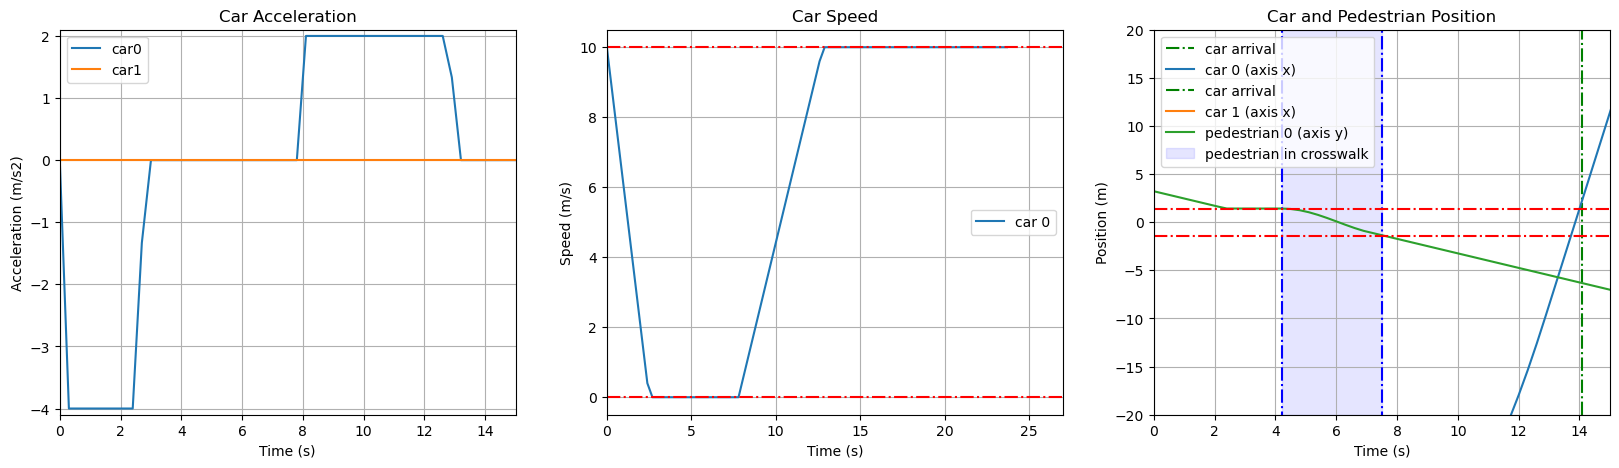

In [32]:
#Showing Vehicle Acceleration Diagram, Vehicle Speed Diagram, Vehicle and Pedestrian Position Diagram
#All three over time in an episode
#t=0
if(t+1>=len(ep_cross)):
    t=0
    u=0
t_init=t
x_car=[t_init]*(2*env.nb_lines)
x_ped1=[t_init]*env.nb_ped
x_ped2=[t_init]*env.nb_ped
while t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
    for i in range(env.nb_ped):
        direction=ep_ped[t_init,i,1]/abs(ep_ped[t_init,i,1])
        if(ep_ped[t,i,3]*direction<=-ep_cross[t_init] and ep_ped[t+1,i,3]*direction>-ep_cross[t_init]):
            x_ped1[i]=t
        if(ep_ped[t,i,3]*direction<=ep_cross[t_init] and ep_ped[t+1,i,3]*direction>ep_cross[t_init]):
            x_ped2[i]=t
    
    for i in range(2*env.nb_lines):
        if(ep_car[t,i,3]<ep_ped[t,0,2] and ep_car[t+1,i,3]>ep_ped[t+1,0,2]): #car finish crossing
            x_car[i]=t
    t+=1
    
for i in range(2*env.nb_lines):
    if(x_car[i]==t_init):
        x_car[i]=t
cross_lines=ep_env[t_init,0]
cross=int((ep_env[t_init,0]*2)/ep_env[t_init,2])

ep_time=[i*0.3 for i in range(t-t_init+1)]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20, 5))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.1,2.1)
ax1.set_xlim(0,15)
for id_car in range(2*env.nb_lines):
    ax1.plot(ep_time, ep_car[t_init:t+1,id_car,0],label='car'+str(id_car)) #-ep_cross[t_init]
ax1.legend()
ax1.grid()

ax3.set_title('Car and Pedestrian Position')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Position (m)")
for id_car in range(2*env.nb_lines):
    ax3.axvline(x=(x_car[id_car]-t_init)*0.3, color='g', linestyle='-.',label='car arrival')
    #print(ep_car[(x_car[id_car]-1):x_car[id_car]+1,0,3])
    #print(ep_ped[(x_car[id_car]-1):x_car[id_car]+1,0,3])
    #print(ep_env[(x_car[id_car])])
    ax3.plot(ep_time, ep_car[t_init:t+1,id_car,3],label='car '+str(id_car)+' (axis x)') #-ep_cross[t_init] -ep_ped[t_init:t+1,0,2]
    print("light : ",ep_car[t_init+1,id_car,4])
    #print("line : ",ep_car[t_init+1,id_car,5])
for id_ped in range(env.nb_ped):
    ax3.plot(ep_time, ep_ped[t_init:t+1,id_ped,3],label='pedestrian '+str(id_ped)+' (axis y)')
    direction=ep_ped[t_init,id_ped,1]/abs(ep_ped[t_init,id_ped,1])
    if direction:
        ax3.axvline(x=(x_ped1[id_ped]-t_init)*0.3,ymin=float(-cross_lines),ymax=float(cross_lines), color='b', linestyle='-.')
        ax3.axvline(x=(x_ped2[id_ped]-t_init)*0.3,ymin=float(-cross_lines),ymax=float(cross_lines), color='b', linestyle='-.')
    else:
        ax3.axvline(x=(x_ped1[id_ped]-t_init)*0.3,ymin=float(cross_lines-cross),ymax=float(cross_lines), color='b', linestyle='-.')
        ax3.axvline(x=(x_ped2[id_ped]-t_init)*0.3,ymin=float(cross_lines-cross),ymax=float(cross_lines), color='b', linestyle='-.')
    ax3.fill_between([(x_ped1[id_ped]-t_init)*0.3,(x_ped2[id_ped]-t_init)*0.3],-20,20, color='b', alpha=0.1,label='pedestrian in crosswalk')
    #ax2.fill_between([(x_ped1-t_init)*0.3,(x_ped2-t_init)*0.3], min(ep_pos_car[t_init],ep_pos_ped[t_init]), min(max(ep_pos_car[min_t+t_init],ep_pos_ped[min_t+t_init]),30), color='r', alpha=0.1,label='pedestrian in crosswalk')
ax3.set_ylim(-20,20)
ax3.set_xlim(0,15)
cross_size=2.0*ep_env[t_init,0]/ep_env[t_init,2]
for i in range(int(ep_env[t_init,2])+1):
    ax3.axhline(y=-ep_cross[t_init] + i*cross_size , color='r', linestyle='-.')
#ax2.axhline(y=0.0, color='b', linestyle='-.')
#ax2.axhline(y=10.0, color='b', linestyle='-.')
ax3.legend()
ax3.grid()

ax2.set_title('Car Speed')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Speed (m/s)")
for id_car in range(env.nb_car):
    ax2.plot(ep_time, ep_car[t_init:t+1,id_car,1],label='car '+str(id_car)) #-ep_cross[t_init]
#ax3.plot(ep_time, ep_speed_car[t_init:t+1],color='r')
ax2.axhline(y=ep_car[t_init,0,1], color='r', linestyle='-.')
ax2.axhline(y=0, color='r', linestyle='-.')
ax2.set_xlim(0,27)
ax2.legend()
ax2.grid()
#ax4.set_title('Pedestrian Speed')
#ax4.set_xlabel("Time (s)")
#ax4.set_ylabel("Speed (m/s)")
#for id_ped in range(env.nb_ped):
#    ax4.plot(ep_time, abs(ep_ped[t_init:t+1,id_ped,1]),label='pedestrian '+str(id_ped))
    #ep_ped[t_init:t+1,id_ped,7]*
##ax4.set_xlim(0,15)
#ax4.legend()
#fig.savefig("Display_Data/Sauvegarde_"+str(is_loading_c)+"_"+str(int(ep_car[t_init+1,0,4]))+"_"+str(int(ep_car[t_init+1,1,4]))+".pdf")    
#print(ep_reward_d)
print("Reward discrete ",ep_reward_d[u])
t+=1
u+=1
print(ep_car[t_init,0,3])
print(ep_car[t_init,1,3])
print(ep_ped[t_init,0,3])
#print(t)
#print(ep_reward_d[u])

In [46]:
ep_car[t_init,0,:]

tensor([ 0.0000, 10.0000,  0.0000, -5.3502,  0.0000,  0.0000,  1.0000])

In [ ]:
#algo.loading(122,9000)
#algo.loading(122,7000)
#algo.loading(122,5000)

#algo.loading(122,6000)
algo.loading(122,3000)

In [ ]:
car_feat_size=7
env_feat_size=3
ped_feat_size=8#.evaluate(1000)
states, actions, rewards_c, rewards_d, time_stop = algo.evaluate(1,choix=True)#evaluate_dataset(100)
#ep_action=states[:,0]
#ep_speed_car=states[:,1]
#ep_pos_car=states[:,2]
#ep_speed_ped=states[:,3]
#ep_pos_ped=states[:,4]
#ep_cross=states[:,9]
ep_reward_d=rewards_d
ep_reward_c=rewards_c
#ep_light=actions[:,1]

lim_car=env.observation_space["car"].shape[0]#env.nb_car*car_feat_size
lim_env=env.observation_space["env"].shape[0]#env.nb_ped*ped_feat_size
lim_ped=env.observation_space["ped"].shape[0]
ep_car = states[:,:lim_car]
ep_car = ep_car.reshape(-1,env.nb_car,int(lim_car/env.nb_car))
ep_env = states[:,lim_car:lim_car+lim_env]
ep_env = ep_env.reshape(-1,lim_env)
ep_ped = states[:,lim_car+lim_env:lim_car+lim_env+lim_ped]
ep_ped = ep_ped.reshape((-1,env.nb_ped,int(lim_ped/env.nb_ped)))
ep_cross=ep_env[:,0]
t=0
u=0
num_episode=0
if(t+1>=len(ep_cross)):
    t=0
    u=0
t_init=t
x_car=[t_init]*env.nb_car
x_ped1=[t_init]*env.nb_ped
x_ped2=[t_init]*env.nb_ped
x_ped3=[t_init]*env.nb_ped
while t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
    for i in range(env.nb_ped):
        direction=ep_ped[t_init,i,1]/abs(ep_ped[t_init,i,1])
        #cross_size=2.0*ep_env[t_init,0]/ep_env[t_init,2]
        if(ep_ped[t,i,3]*direction<=-ep_cross[t_init] and ep_ped[t+1,i,3]*direction>-ep_cross[t_init]):
            x_ped1[i]=t
        if(ep_ped[t,i,3]*direction<=0. and ep_ped[t+1,i,3]*direction>0.):
            x_ped2[i]=t
        if(ep_ped[t,i,3]*direction<=ep_cross[t_init] and ep_ped[t+1,i,3]*direction>ep_cross[t_init]):
            x_ped3[i]=t
    
    for i in range(env.nb_car):
        if(ep_car[t,i,3]<ep_ped[t,0,2] and ep_car[t+1,i,3]>ep_ped[t+1,0,2]): #car finish crossing
            x_car[i]=t
    t+=1
    
for i in range(env.nb_car):
    if(x_car[i]==t_init):
        x_car[i]=t
cross_lines=ep_env[t_init,0]
cross=int((ep_env[t_init,0]*2)/ep_env[t_init,2])
x_ped=[x_ped1,x_ped2,x_ped3]
ep_time=[i*0.3 for i in range(t-t_init+1)]
fig, axs = plt.subplots(2, 2,figsize=(14, 10))
for axe_x in range(len(axs)):
    axs[axe_x][0].set_title('Car Speed')
    axs[axe_x][0].set_xlabel("Time (s)")
    axs[axe_x][0].set_ylabel("Speed (m/s)")
    #for id_car in range(env.nb_car):
    axs[axe_x][0].plot(ep_time, ep_car[t_init:t+1,axe_x,1],label='car '+str(axe_x)) #-ep_cross[t_init]
    #ax3.plot(ep_time, ep_speed_car[t_init:t+1],color='r')
    axs[axe_x][0].axhline(y=ep_car[t_init,0,1], color='r', linestyle='-.')
    axs[axe_x][0].axhline(y=0, color='r', linestyle='-.')
    axs[axe_x][0].set_xlim(0,15)
    axs[axe_x][0].legend()
    axs[axe_x][0].grid()
    
    axs[axe_x][1].set_title('Car and Pedestrian Position')
    axs[axe_x][1].set_xlabel("Time (s)")
    axs[axe_x][1].set_ylabel("Position (m)")
    axs[axe_x][1].axvline(x=(x_car[axe_x]-t_init)*0.3, color='g', linestyle='-.',label='car arrival')
    #print(ep_car[(x_car[id_car]-1):x_car[id_car]+1,0,3])
    #print(ep_ped[(x_car[id_car]-1):x_car[id_car]+1,0,3])
    #print(ep_env[(x_car[id_car])])
    axs[axe_x][1].plot(ep_time, ep_car[t_init:t+1,axe_x,3],label='car '+str(axe_x)+' (axis x)') #-ep_cross[t_init] -ep_ped[t_init:t+1,0,2]
    print("light : ",ep_car[t_init+1,axe_x,4])
    print("line : ",ep_car[t_init+1,axe_x,5])
    for id_ped in range(env.nb_ped):
        axs[axe_x][1].plot(ep_time, ep_ped[t_init:t+1,id_ped,3],label='pedestrian '+str(id_ped)+' (axis y)')
        direction=ep_ped[t_init,id_ped,1]/abs(ep_ped[t_init,id_ped,1])
        car_lane=int(ep_car[t_init+1,axe_x,5])
        print(direction)
        if direction>0:
            axs[axe_x][1].axvline(x=(x_ped[car_lane][id_ped]-t_init)*0.3,ymin=float(-cross_lines),ymax=float(cross_lines), color='b', linestyle='-.')
            axs[axe_x][1].axvline(x=(x_ped[car_lane+1][id_ped]-t_init)*0.3,ymin=float(-cross_lines),ymax=float(cross_lines), color='b', linestyle='-.')
            axs[axe_x][1].fill_between([(x_ped[car_lane][id_ped]-t_init)*0.3,(x_ped[car_lane+1][id_ped]-t_init)*0.3],-20,20, color='b', alpha=0.05,label='pedestrian in lane')

        else:
            #print(ep_env[t_init,2]-car_lane)
            axs[axe_x][1].axvline(x=(x_ped[int(ep_env[t_init,2])-car_lane][id_ped]-t_init)*0.3,ymin=float(-cross_lines),ymax=float(cross_lines), color='b', linestyle='-.')
            axs[axe_x][1].axvline(x=(x_ped[int(ep_env[t_init,2])-car_lane-1][id_ped]-t_init)*0.3,ymin=float(-cross_lines),ymax=float(cross_lines), color='b', linestyle='-.')
            axs[axe_x][1].fill_between([(x_ped[int(ep_env[t_init,2])-car_lane][id_ped]-t_init)*0.3,(x_ped[int(ep_env[t_init,2])-car_lane-1][id_ped]-t_init)*0.3],-20,20, color='b', alpha=0.05,label='pedestrian in lane')
        #ax2.fill_between([(x_ped1-t_init)*0.3,(x_ped2-t_init)*0.3], min(ep_pos_car[t_init],ep_pos_ped[t_init]), min(max(ep_pos_car[min_t+t_init],ep_pos_ped[min_t+t_init]),30), color='r', alpha=0.1,label='pedestrian in crosswalk')
    axs[axe_x][1].set_ylim(-20,20)
    axs[axe_x][1].set_xlim(0,15)
    cross_size=2.0*ep_env[t_init,0]/ep_env[t_init,2]
    for i in range(2):#int(ep_env[t_init,2])+1):
        axs[axe_x][1].axhline(y=-ep_cross[t_init] + (ep_car[t_init+1,axe_x,5]+i)*cross_size , color='r', linestyle='-.')
    #ax2.axhline(y=0.0, color='b', linestyle='-.')
    #ax2.axhline(y=10.0, color='b', linestyle='-.')
    axs[axe_x][1].legend()
    axs[axe_x][1].grid()
    
t+=1
u+=1
print("num_episode : ",num_episode)
print("t : ",t)
num_episode+=1
#fig.savefig('coop_example.svg', format='svg')
#print(t)
#print(ep_reward_d[u])

In [ ]:
#Stock an evaluation sample
car_feat_size=7
env_feat_size=3
ped_feat_size=8#.evaluate(1000)
states, actions, rewards_c, rewards_d, time_stop = algo.evaluate_dataset(1000)
#ep_action=states[:,0]
#ep_speed_car=states[:,1]
#ep_pos_car=states[:,2]
#ep_speed_ped=states[:,3]
#ep_pos_ped=states[:,4]
#ep_cross=states[:,9]
ep_reward_d=rewards_d
ep_reward_c=rewards_c
#ep_light=actions[:,1]

lim_car=env.observation_space["car"].shape[0]#env.nb_car*car_feat_size
lim_env=env.observation_space["env"].shape[0]#env.nb_ped*ped_feat_size
lim_ped=env.observation_space["ped"].shape[0]
ep_car = states[:,:lim_car]
ep_car = ep_car.reshape(-1,env.nb_car,int(lim_car/env.nb_car))
ep_env = states[:,lim_car:lim_car+lim_env]
ep_env = ep_env.reshape(-1,lim_env)
ep_ped = states[:,lim_car+lim_env:lim_car+lim_env+lim_ped]
ep_ped = ep_ped.reshape((-1,env.nb_ped,int(lim_ped/env.nb_ped)))
ep_cross=ep_env[:,0]
t=0
u=0
#t_init=t
#print(ep_reward_c.shape)
#print(ep_reward_d.shape)
#print(actions)
#ep_reward_d.flatten()

In [ ]:
torch.mean(time_stop)

In [ ]:
from matplotlib.ticker import PercentFormatter
plt.title("Histogram of pedestrian waiting time on sidewalk")

plt.xlabel('Waiting time')
plt.ylabel('Percentage')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.hist(time_stop, bins=10, weights=np.ones(len(time_stop)) / len(time_stop))

In [ ]:
#Showing Vehicle Acceleration Diagram, Vehicle Speed Diagram, Vehicle and Pedestrian Position Diagram
#All three over time in an episode
#t=0
if(t+1>=len(ep_cross)):
    t=0
    u=0
t_init=t
x_car=[t_init]*env.nb_car
x_ped1=[t_init]*env.nb_ped
x_ped2=[t_init]*env.nb_ped
while t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
    for i in range(env.nb_ped):
        direction=ep_ped[t_init,i,1]/abs(ep_ped[t_init,i,1])
        if(ep_ped[t,i,3]*direction<=-ep_cross[t_init] and ep_ped[t+1,i,3]*direction>-ep_cross[t_init]):
            x_ped1[i]=t
        if(ep_ped[t,i,3]*direction<=ep_cross[t_init] and ep_ped[t+1,i,3]*direction>ep_cross[t_init]):
            x_ped2[i]=t
    
    for i in range(env.nb_car):
        if(ep_car[t,i,3]<ep_ped[t,0,2] and ep_car[t+1,i,3]>ep_ped[t+1,0,2]): #car finish crossing
            x_car[i]=t
    t+=1
    
for i in range(env.nb_car):
    if(x_car[i]==t_init):
        x_car[i]=t
cross_lines=ep_env[t_init,0]
cross=int((ep_env[t_init,0]*2)/ep_env[t_init,2])

ep_time=[i*0.3 for i in range(t-t_init+1)]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20, 5))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.1,2.1)
ax1.set_xlim(0,15)
for id_car in range(env.nb_car):
    ax1.plot(ep_time, ep_car[t_init:t+1,id_car,0],label='car'+str(id_car)) #-ep_cross[t_init]
ax1.legend()
ax1.grid()

ax3.set_title('Car and Pedestrian Position')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Position (m)")
for id_car in range(env.nb_car):
    ax3.axvline(x=(x_car[id_car]-t_init)*0.3, color='g', linestyle='-.',label='car arrival')
    #print(ep_car[(x_car[id_car]-1):x_car[id_car]+1,0,3])
    #print(ep_ped[(x_car[id_car]-1):x_car[id_car]+1,0,3])
    #print(ep_env[(x_car[id_car])])
    ax3.plot(ep_time, ep_car[t_init:t+1,id_car,3],label='car '+str(id_car)+' (axis x)') #-ep_cross[t_init] -ep_ped[t_init:t+1,0,2]
    print("light : ",ep_car[t_init+1,id_car,4])
    #print("line : ",ep_car[t_init+1,id_car,5])
for id_ped in range(env.nb_ped):
    ax3.plot(ep_time, ep_ped[t_init:t+1,id_ped,3],label='pedestrian '+str(id_ped)+' (axis y)')
    direction=ep_ped[t_init,id_ped,1]/abs(ep_ped[t_init,id_ped,1])
    if direction:
        ax3.axvline(x=(x_ped1[id_ped]-t_init)*0.3,ymin=float(-cross_lines),ymax=float(cross_lines), color='b', linestyle='-.')
        ax3.axvline(x=(x_ped2[id_ped]-t_init)*0.3,ymin=float(-cross_lines),ymax=float(cross_lines), color='b', linestyle='-.')
    else:
        ax3.axvline(x=(x_ped1[id_ped]-t_init)*0.3,ymin=float(cross_lines-cross),ymax=float(cross_lines), color='b', linestyle='-.')
        ax3.axvline(x=(x_ped2[id_ped]-t_init)*0.3,ymin=float(cross_lines-cross),ymax=float(cross_lines), color='b', linestyle='-.')
    ax3.fill_between([(x_ped1[id_ped]-t_init)*0.3,(x_ped2[id_ped]-t_init)*0.3],-20,20, color='b', alpha=0.1,label='pedestrian in crosswalk')
    #ax2.fill_between([(x_ped1-t_init)*0.3,(x_ped2-t_init)*0.3], min(ep_pos_car[t_init],ep_pos_ped[t_init]), min(max(ep_pos_car[min_t+t_init],ep_pos_ped[min_t+t_init]),30), color='r', alpha=0.1,label='pedestrian in crosswalk')
ax3.set_ylim(-20,20)
ax3.set_xlim(0,15)
cross_size=2.0*ep_env[t_init,0]/ep_env[t_init,2]
for i in range(int(ep_env[t_init,2])+1):
    ax3.axhline(y=-ep_cross[t_init] + i*cross_size , color='r', linestyle='-.')
#ax2.axhline(y=0.0, color='b', linestyle='-.')
#ax2.axhline(y=10.0, color='b', linestyle='-.')
ax3.legend()
ax3.grid()

ax2.set_title('Car Speed')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Speed (m/s)")
for id_car in range(env.nb_car):
    ax2.plot(ep_time, ep_car[t_init:t+1,id_car,1],label='car '+str(id_car)) #-ep_cross[t_init]
#ax3.plot(ep_time, ep_speed_car[t_init:t+1],color='r')
ax2.axhline(y=ep_car[t_init,0,1], color='r', linestyle='-.')
ax2.axhline(y=0, color='r', linestyle='-.')
ax2.set_xlim(0,27)
ax2.legend()
ax2.grid()
#ax4.set_title('Pedestrian Speed')
#ax4.set_xlabel("Time (s)")
#ax4.set_ylabel("Speed (m/s)")
#for id_ped in range(env.nb_ped):
#    ax4.plot(ep_time, abs(ep_ped[t_init:t+1,id_ped,1]),label='pedestrian '+str(id_ped))
    #ep_ped[t_init:t+1,id_ped,7]*
##ax4.set_xlim(0,15)
#ax4.legend()
#fig.savefig("Display_Data/Sauvegarde_"+str(is_loading_c)+"_"+str(int(ep_car[t_init+1,0,4]))+"_"+str(int(ep_car[t_init+1,1,4]))+".pdf")    
#print(ep_reward_d)
print("Reward discrete ",ep_reward_d[u])
t+=1
u+=1
print(ep_car[t_init,0,3])
print(ep_car[t_init,1,3])
print(ep_ped[t_init,0,3])
#print(t)
#print(ep_reward_d[u])

In [ ]:
import pandas as pd
LDV = pd.read_csv('LDV.csv', sep=';',names=["sp","acc","step","em_name","em_val"])
LDV.pop('step')
m = LDV == 0.0
LDV['acc'] = LDV['acc'].replace(1.27676e-15,0.0)
LDV['acc'] = LDV['acc'].astype(float)
LDV_array = np.array(LDV.values)

def info_co2(ep_car,ep_cross,LDV):
    """
        Evaluate the CO2 emission per episode 
        :param states: state list
        :param LDV: CO2 emission chart
    """
    t=0
    total_emission=[]
    while t+1<len(ep_cross):
        t_init=t
        emission_val=[]
        for car_i in range(env.nb_car):
            while  t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
                acc=math.trunc(((ep_car[t,car_i,0].item()//0.2)*0.2)*10.)/10.
                speed=math.trunc(((ep_car[t,car_i,1].item()//0.5)*0.5)*10.)/10.
                cond=(LDV.sp==speed)&(LDV.acc==acc)&(LDV.em_name=="CO2")
                res=LDV[cond]['em_val'].item() *0.3
                emission_val.append(res)
                t+=1
            total_emission.append(np.sum(np.array(emission_val),axis=0))
        t+=1
    torch_total_emission=np.array(total_emission)
    total_emission_mean=np.mean(torch_total_emission)
    total_emission_std=np.std(torch_total_emission)
    print("\nThe average CO2 emission is {:.2f}mg and its standard deviation is {:.2f} mg".format(total_emission_mean.item(),total_emission_std.item()))
    
def get_average(ep_car,ep_ped,ep_cross):
    ep_time=states[:,9]
    #Info vitesse voiture
    mean_speed=torch.mean(ep_car[:,0,1])
    sqrt_speed=torch.std(ep_car[:,0,1])
    print("La vitesse moyenne (voiture) est de {:.2f} m/s et son écart-type est de {:.2f} m/s".format(mean_speed.item(),sqrt_speed.item()))
    #Info accélération voiture RMQ: très peu représentatif...
    mean_acc=torch.mean(torch.abs(ep_car[:,0,0]))
    sqrt_acc=torch.std(ep_car[:,0,0])
    print("\nL'accélération moyenne (voiture) est de {:.2f} m/s2 et son écart-type est de {:.2f} m/s2".format(mean_acc.item(),sqrt_acc.item()))
    mean_speed_p=torch.mean(torch.abs(ep_ped[:,0,1]))
    sqrt_speed_p=torch.std(torch.abs(ep_ped[:,0,1]))
    print("\nLa vitesse moyenne (piéton) est de {:.2f} m/s et son écart-type est de {:.2f} m/s".format(mean_speed_p.item(),sqrt_speed_p.item()))    
    #CO2 info
    info_co2(ep_car,ep_cross,LDV) #CO2 info
    #temps passage voiture
    temp_cars=[]
    all_temp_cars=[]
    temp_peds=[]
    finish_cross_interact=[]
    finish_cross_nointeract=[]
    decisions=[]
    ped_direction=[]
    waiting_times=[]
    speed_cars=[]
    all_decisions=[]
    could_stop=[]
    t=0
    while t+1<len(ep_cross):
        # respectivement: temps passage voiture / piéton
        t_init=t
        t_end=t
        #temp_ped=np.array([0.]*env.nb_ped)
        for ped_i in range(env.nb_ped):
            waiting_time=0
            ped_leave=0
            t=t_init
            while t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
                if abs(ep_ped[t,ped_i,3])==ep_cross[t] and abs(ep_ped[t+1,ped_i,3])==ep_cross[t+1]:
                #if(ep_ped[t,ped_i,1]==0.):
                    waiting_time+=0.3
                if abs(ep_ped[t,ped_i,3])==0 and abs(ep_ped[t+1,ped_i,3])==0:
                #if(ep_ped[t,ped_i,1]==0.):
                    waiting_time+=0.3
                if(ep_ped[t,ped_i,3]*ep_ped[t,ped_i,8]<ep_cross[t] and ep_ped[t+1,ped_i,3]*ep_ped[t+1,ped_i,8]>=ep_cross[t+1]):
                    ped_leave=(t-t_init)*0.3
                t+=1
            if(ped_leave==0):
                ped_leave=(t-t_init)*0.3
            temp_peds.append(ped_leave)
            finish_cross_interact.append(ped_leave)
            finish_cross_nointeract.append(ped_leave-waiting_time)
            waiting_times.append(waiting_time)
            ped_direction.append(int(-ep_ped[t_init,ped_i,8]/2. +0.5))
            t_end=max(t_end,t)
       # temp_peds.append(temp_ped)
        #temp_car=np.array([0.]*env.nb_car)
        for car_i in range(env.nb_car):
            t=t_init
            car_leave=0
            finish_cross_nointeract.append((25.-ep_car[t_init,car_i,3])/ep_car[t_init,car_i,1])
            if(ep_car[t_init+1,car_i,4]<0.):
                if(-ep_car[t_init,car_i,3]-(ep_car[t_init,car_i,1]* ep_car[t_init,car_i,1] / (8.) + ep_car[t_init,car_i,1])>0.):
                    could_stop.append(1)
                else:
                    could_stop.append(0)
            while t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
                decision=ep_car[t,car_i,4]
                if(ep_car[t_init+1,car_i,4]==1):
                    speed_cars.append(ep_car[t,car_i,1])
                if(ep_car[t,car_i,3]-max(ep_ped[t+1,:,2])-25<0.0 and ep_car[t+1,car_i,3]-max(ep_ped[t+1,:,2])-25>=0.0):
                    car_leave=(t-t_init)*0.3
                if(ep_car[t,car_i,3]-max(ep_ped[t+1,:,2])-25<0.0 and ep_car[t+1,car_i,3]-max(ep_ped[t+1,:,2])-25>=0.0)and (ep_car[t_init+1,car_i,4]==1):
                    temp_cars.append((t-t_init)*0.3)
                    #speed_cars.append(ep_car[t,car_i,1])
                t+=1
            if(ep_car[t_init+1,car_i,4]==1):
                decisions.append(decision)
            if(car_leave==0):
                car_leave=(t-t_init)*0.3
            all_decisions.append(decision)
            all_temp_cars.append(car_leave)
            finish_cross_interact.append(car_leave)
            t_end=max(t_end,t)
        #temp_cars.append(temp_car)
            #temps.append([(t-t_init)*0.3,temps_i[0],temps_i[1]])
        t=t_end+1
    #total_temps=torch.tensor([temps]).reshape((-1,3))
    mean_speed_cars=torch.mean(torch.tensor(speed_cars).flatten())
    sqrt_speed_cars=torch.std(torch.tensor(speed_cars).flatten())
    mean_temp_cars=torch.mean(torch.tensor(temp_cars).flatten())
    mean_all_temp_cars=torch.mean(torch.tensor(all_temp_cars).flatten())
    mean_temp_peds=torch.mean(torch.tensor(temp_peds).flatten())
    #decisions_tensor=torch.tensor(decisions).reshape(-1,env.nb_car)
    all_decisions_tensor=torch.tensor(all_decisions).reshape(-1,env.nb_car)
    all_scenario=torch.sum(all_decisions_tensor, axis=1)
    #scenario=torch.sum(decisions_tensor, axis=1)
    max_finish_cross_interact=torch.max(torch.tensor(finish_cross_interact).reshape(-1,env.nb_car+env.nb_ped),dim=1, keepdim=True).values
    #print(max_finish_cross_interact)
    max_finish_cross_nointeract=torch.max(torch.tensor(finish_cross_nointeract).reshape(-1,env.nb_car+env.nb_ped),dim=1, keepdim=True).values
    interaction_cost=max_finish_cross_interact-max_finish_cross_nointeract
    max_finish_compare=torch.tensor(finish_cross_interact).reshape(-1,env.nb_car+env.nb_ped)-torch.tensor(finish_cross_nointeract).reshape(-1,env.nb_car+env.nb_ped)#,dim=1)

    print("La vitesse moyenne (voiture 1) est de {:.2f} m/s et son écart-type est de {:.2f} m/s".format(mean_speed_cars.item(),sqrt_speed_cars.item()))
    print("Le cout de l'interaction est de :",torch.mean(interaction_cost))
    print("Le cout max de l'interaction est de :",torch.mean(max_finish_compare))
    
    print("\nLes temps moyens:")
    print("voiture 1 a 25 metres: {:.2f} s".format(mean_temp_cars))
    print("voiture 1 a 25 metres std: ", torch.std(torch.tensor(temp_cars)))
    print("voiture a 25 metres all: {:.2f} s".format(mean_all_temp_cars))
    print("voiture a 25 metres all std: ", torch.std(torch.tensor(all_temp_cars)))
    print("piéton: {:.2f} s".format(mean_temp_peds))
    print("piéton std: ", torch.std(torch.tensor(temp_peds)))
    print("Yield decision: ", sum([1 for dec in np.array(all_decisions) if dec ==1])/len(all_scenario))
    print("Go first decision: ", sum([1 for dec in np.array(all_decisions) if dec ==-1])/len(all_scenario))
    print("Le temps moyen d'attente du pieton: ", np.mean(waiting_times))
    print("Le temps std d'attente du pieton: ", np.std(waiting_times))
    print("Percentage of forced stop % refuse to stop: ", np.mean(could_stop))
    if(env.nb_car==2):
        print("Scenario 1 1: ", sum([1 for sce in (all_decisions_tensor) if sum(sce) ==2])/len(all_scenario))
        print("Scenario -1 -1: ", sum([1 for sce in (all_decisions_tensor) if sum(sce) ==-2])/len(all_scenario))
        print("Scenario -1 1: ", sum([1 for sce in (all_decisions_tensor) if sce[0] ==-1 and sce[1]==1])/len(all_scenario))
        print("Scenario 1 -1: ", sum([1 for sce in (all_decisions_tensor) if sce[0] ==1 and sce[1]==-1])/len(all_scenario))
    #print(torch.std(total_temps,dim=0))
get_average(ep_car,ep_ped,ep_cross)


In [ ]:
import pandas as pd
LDV = pd.read_csv('LDV.csv', sep=';',names=["sp","acc","step","em_name","em_val"])
LDV.pop('step')
m = LDV == 0.0
LDV['acc'] = LDV['acc'].replace(1.27676e-15,0.0)
LDV['acc'] = LDV['acc'].astype(float)
LDV_array = np.array(LDV.values)

def info_co2(ep_car,ep_cross,LDV):
    """
        Evaluate the CO2 emission per episode 
        :param states: state list
        :param LDV: CO2 emission chart
    """
    t=0
    total_emission=[]
    while t+1<len(ep_cross):
        t_init=t
        emission_val=[]
        for car_i in range(env.nb_car):
            while  t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
                acc=math.trunc(((ep_car[t,car_i,0].item()//0.2)*0.2)*10.)/10.
                speed=math.trunc(((ep_car[t,car_i,1].item()//0.5)*0.5)*10.)/10.
                cond=(LDV.sp==speed)&(LDV.acc==acc)&(LDV.em_name=="CO2")
                res=LDV[cond]['em_val'].item() *0.3
                emission_val.append(res)
                t+=1
            total_emission.append(np.sum(np.array(emission_val),axis=0))
        t+=1
    torch_total_emission=np.array(total_emission)
    total_emission_mean=np.mean(torch_total_emission)
    total_emission_std=np.std(torch_total_emission)
    print("\nThe average CO2 emission is {:.2f}mg and its standard deviation is {:.2f} mg".format(total_emission_mean.item(),total_emission_std.item()))
    
def get_average(ep_car,ep_ped,ep_cross):
    ep_time=states[:,9]
    #Info vitesse voiture
    mean_speed=torch.mean(ep_car[:,0,1])
    sqrt_speed=torch.std(ep_car[:,0,1])
    print("La vitesse moyenne (voiture) est de {:.2f} m/s et son écart-type est de {:.2f} m/s".format(mean_speed.item(),sqrt_speed.item()))
    #Info accélération voiture RMQ: très peu représentatif...
    mean_acc=torch.mean(torch.abs(ep_car[:,0,0]))
    sqrt_acc=torch.std(ep_car[:,0,0])
    print("\nL'accélération moyenne (voiture) est de {:.2f} m/s2 et son écart-type est de {:.2f} m/s2".format(mean_acc.item(),sqrt_acc.item()))
    mean_speed_p=torch.mean(torch.abs(ep_ped[:,0,1]))
    sqrt_speed_p=torch.std(torch.abs(ep_ped[:,0,1]))
    print("\nLa vitesse moyenne (piéton) est de {:.2f} m/s et son écart-type est de {:.2f} m/s".format(mean_speed_p.item(),sqrt_speed_p.item()))    
    #CO2 info
    info_co2(ep_car,ep_cross,LDV) #CO2 info
    #temps passage voiture
    temp_cars=[]
    all_temp_cars=[]
    temp_peds=[]
    decisions=[]
    speed_cars=[]
    all_decisions=[]
    waiting_times=[]
    t=0
    while t+1<len(ep_cross):
        # respectivement: temps passage voiture / piéton
        t_init=t
        t_end=t
        #if(1 in ep_car[t_init+1,:,4]):
        
        #temp_ped=np.array([0.]*env.nb_ped)
        for ped_i in range(env.nb_ped):
            waiting_time=0
            t=t_init
            while t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
                if(ep_ped[t,ped_i,3])==ep_cross[t]:
                    waiting_time+=0.3
                if(ep_ped[t,ped_i,3]*ep_ped[t,ped_i,8]<ep_cross[t] and ep_ped[t+1,ped_i,3]*ep_ped[t+1,ped_i,8]>=ep_cross[t+1]):
                    temp_peds.append((t-t_init)*0.3)
                t+=1
            waiting_times.append(waiting_time)
            t_end=max(t_end,t)
       # temp_peds.append(temp_ped)
        #temp_car=np.array([0.]*env.nb_car)
        for car_i in range(env.nb_car):
            t=t_init
            #if(1 in ep_car[t_init+1,:,4]):
            while t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
                decision=ep_car[t,car_i,4]
                if(ep_car[t,car_i,3]-max(ep_ped[t+1,:,2])<0.0 and ep_car[t+1,car_i,3]-max(ep_ped[t+1,:,2])>=0.0):
                    all_temp_cars.append((t-t_init)*0.3)
                if(ep_car[t,car_i,3]-max(ep_ped[t+1,:,2])<0.0 and ep_car[t+1,car_i,3]-max(ep_ped[t+1,:,2])>=0.0) and (ep_car[t_init+1,car_i,4]==1):
                    temp_cars.append((t-t_init)*0.3)
                    speed_cars.append(ep_car[t,car_i,1])
                t+=1
            if(ep_car[t_init+1,car_i,4]==1):
                decisions.append(decision)
            all_decisions.append(decision)
            t_end=max(t_end,t)
        #temp_cars.append(temp_car)
            #temps.append([(t-t_init)*0.3,temps_i[0],temps_i[1]])
        t=t_end+1
    #total_temps=torch.tensor([temps]).reshape((-1,3))
    mean_speed_cars=torch.mean(torch.tensor(speed_cars).flatten())
    sqrt_speed_cars=torch.std(torch.tensor(speed_cars).flatten())
    mean_temp_cars=torch.mean(torch.tensor(temp_cars).flatten())
    mean_all_temp_cars=np.mean(np.array(all_temp_cars).flatten())
    mean_temp_peds=torch.mean(torch.tensor(temp_peds).flatten())
    #decisions_tensor=torch.tensor(decisions).flatten()#.reshape(-1,env.nb_car)
    all_decisions_tensor=torch.tensor(all_decisions).reshape(-1,env.nb_car)
    #print(all_decisions_tensor)
    #scenario=torch.sum(decisions_tensor, axis=1)
    all_scenario=torch.sum(all_decisions_tensor, axis=1)
    print("La vitesse moyenne (voiture 1) est de {:.2f} m/s et son écart-type est de {:.2f} m/s".format(mean_speed_cars.item(),sqrt_speed_cars.item()))
    print("\nLes temps moyens:")
    print("voiture 1: {:.2f} s".format(mean_temp_cars))
    print("voiture 1 std: ", torch.std(torch.tensor(temp_cars)))
    print("voiture all: {:.2f} s".format(mean_all_temp_cars))
    print("voiture all std: ", np.std(np.array(all_temp_cars)))
    print("piéton: {:.2f} s".format(mean_temp_peds))
    print("piéton std: ", torch.std(torch.tensor(temp_peds)))
    print("Yield decision: ", sum([1 for dec in np.array(all_decisions) if dec ==1])/len(all_scenario))
    print("Go first decision: ", sum([1 for dec in np.array(all_decisions) if dec ==-1])/len(all_scenario))
    print("Le temps moyen d'attente du pieton: ", np.mean(waiting_times))
    print("Le temps std d'attente du pieton: ", np.std(waiting_times))
    print("Scenario 1 1: ", sum([1 for sce in (all_decisions_tensor) if sum(sce) ==2])/len(all_scenario))
    print("Scenario -1 -1: ", sum([1 for sce in (all_decisions_tensor) if sum(sce) ==-2])/len(all_scenario))
    print("Scenario -1 1: ", sum([1 for sce in (all_decisions_tensor) if sce[0] ==-1 and sce[1]==1])/len(all_scenario))
    print("Scenario 1 -1: ", sum([1 for sce in (all_decisions_tensor) if sce[0] ==1 and sce[1]==-1])/len(all_scenario))
    #print(torch.std(total_temps,dim=0))
get_average(ep_car,ep_ped,ep_cross)


In [ ]:
all_decisions_tensor

In [ ]:
env.pedestrian[0].waiting_time

In [ ]:
    
ep_time=[i*0.3 for i in range(t-t_init+1)]
fig, ( ax4, ax5, ax6, ax7) = plt.subplots(1, 4,figsize=(20, 8))

ax4.set_title('Delta')
ax4.set_xlabel("Time (s)")
ax4.set_ylabel("")
for id_ped in range(env.nb_ped):
    ax4.plot(ep_time, ep_ped[t_init:t+1,id_ped,4],label='pedestrian'+str(id_ped))
ax4.legend()
    
    
ax5.set_title('Pedestrian position axe X')
ax5.set_xlabel("Time (s)")
ax5.set_ylabel("Speed (m/s)")
for id_ped in range(env.nb_ped):
    ax5.plot(ep_time, ep_ped[t_init:t+1,id_ped,1],label='pedestrian'+str(id_ped))
ax5.legend()
ax5.set_xlim(0,15)
#ax5.set_title('DL')
#ax5.set_xlabel("Time (s)")
#ax5.set_ylabel("Value ")
#ax5.plot(ep_time, states[t_init:t+1,5 ])#ep_reward[t_init:t+1])#ep_reward[t_init:t+1],color='r')
#ax5.axhline(y=0, color='r', linestyle='-.')

ax6.set_title('Reward')
ax6.set_xlabel("Time (s)")
ax6.set_ylabel("Value")
for id_car in range(env.nb_car):
    ax6.plot(ep_time,ep_reward_c[t_init:t+1][:,id_car],label='car'+str(id_car))#ep_reward[t_init:t+1])#ep_reward[t_init:t+1],color='r')
ax6.legend()
#print(ep_reward_d)
ax7.set_title('Light')
ax7.set_xlabel("Time (s)")
ax7.set_ylabel("Light")
for id_car in range(env.nb_car):
    ax7.plot(ep_time,ep_car[t_init:t+1,id_car,4],label='car'+str(id_car))#,color='black')#ep_reward[t_init:t+1])#ep_reward[t_init:t+1],color='r')
    #ax7.scatter(ep_time,ep_car[t_init:t+1,id_car,4],c=ep_car[t_init:t+1,id_car,4],cmap='RdYlGn')
    ax7
    ax7.legend()
#print(ep_reward_d)
t+=1
print(t)

In [ ]:
import copy
import pickle
 
def save_object(obj):
    try:
        with open("test_data_coop.pickle", "wb") as f:
            pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as ex:
        print("Error during pickling object (Possibly unsupported):", ex)
dataset=[]
for i in range(1000):
    env.reset()
    dataset.append(copy.deepcopy(env))
save_object(dataset)

In [ ]:
import pandas as pd
LDV = pd.read_csv('LDV.csv', sep=';',names=["sp","acc","step","em_name","em_val"])
LDV.pop('step')
m = LDV == 0.0
LDV['acc'] = LDV['acc'].replace(1.27676e-15,0.0)
LDV['acc'] = LDV['acc'].astype(float)
LDV_array = np.array(LDV.values)

def info_co2(ep_car,ep_cross,LDV):
    """
        Evaluate the CO2 emission per episode 
        :param states: state list
        :param LDV: CO2 emission chart
    """
    t=0
    total_emission=[]
    while t+1<len(ep_cross):
        t_init=t
        emission_val=[]
        for car_i in range(env.nb_car):
            while  t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
                acc=math.trunc(((ep_car[t,car_i,0].item()//0.2)*0.2)*10.)/10.
                speed=math.trunc(((ep_car[t,car_i,1].item()//0.5)*0.5)*10.)/10.
                cond=(LDV.sp==speed)&(LDV.acc==acc)&(LDV.em_name=="CO2")
                res=LDV[cond]['em_val'].item() *0.3
                emission_val.append(res)
                t+=1
            total_emission.append(np.sum(np.array(emission_val),axis=0))
        t+=1
    torch_total_emission=np.array(total_emission)
    total_emission_mean=np.mean(torch_total_emission)
    total_emission_std=np.std(torch_total_emission)
    print("\nThe average CO2 emission is {:.2f}mg and its standard deviation is {:.2f} mg".format(total_emission_mean.item(),total_emission_std.item()))
    
def get_average(ep_car,ep_ped,ep_cross):
    ep_time=states[:,9]
    #Info vitesse voiture
    mean_speed=torch.mean(ep_car[:,0,1])
    sqrt_speed=torch.std(ep_car[:,0,1])
    print("La vitesse moyenne (voiture) est de {:.2f} m/s et son écart-type est de {:.2f} m/s".format(mean_speed.item(),sqrt_speed.item()))
    #Info accélération voiture RMQ: très peu représentatif...
    mean_acc=torch.mean(torch.abs(ep_car[:,0,0]))
    sqrt_acc=torch.std(ep_car[:,0,0])
    print("\nL'accélération moyenne (voiture) est de {:.2f} m/s2 et son écart-type est de {:.2f} m/s2".format(mean_acc.item(),sqrt_acc.item()))
    mean_speed_p=torch.mean(torch.abs(ep_ped[:,0,1]))
    sqrt_speed_p=torch.std(torch.abs(ep_ped[:,0,1]))
    print("\nLa vitesse moyenne (piéton) est de {:.2f} m/s et son écart-type est de {:.2f} m/s".format(mean_speed_p.item(),sqrt_speed_p.item()))    
    #CO2 info
    info_co2(ep_car,ep_cross,LDV) #CO2 info
    #temps passage voiture
    temp_cars=[]
    all_temp_cars=[]
    temp_peds=[]
    finish_cross_interact=[]
    finish_cross_nointeract=[]
    decisions=[]
    ped_direction=[]
    waiting_times=[]
    speed_cars=[]
    all_decisions=[]
    t=0
    while t+1<len(ep_cross):
        # respectivement: temps passage voiture / piéton
        t_init=t
        t_end=t
        #temp_ped=np.array([0.]*env.nb_ped)
        for ped_i in range(env.nb_ped):
            waiting_time=0
            ped_leave=0
            t=t_init
            while t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
                if abs(ep_ped[t,ped_i,3])==ep_cross[t] and abs(ep_ped[t+1,ped_i,3])==ep_cross[t+1]:
                #if(ep_ped[t,ped_i,1]==0.):
                    waiting_time+=0.3
                if abs(ep_ped[t,ped_i,3])==0 and abs(ep_ped[t+1,ped_i,3])==0:
                #if(ep_ped[t,ped_i,1]==0.):
                    waiting_time+=0.3
                if(ep_ped[t,ped_i,3]*ep_ped[t,ped_i,8]<ep_cross[t] and ep_ped[t+1,ped_i,3]*ep_ped[t+1,ped_i,8]>=ep_cross[t+1]):
                    ped_leave=(t-t_init)*0.3
                t+=1
            if(ped_leave==0):
                ped_leave=(t-t_init)*0.3
            temp_peds.append(ped_leave)
            finish_cross_interact.append(ped_leave)
            finish_cross_nointeract.append(ped_leave-waiting_time)
            waiting_times.append(waiting_time)
            ped_direction.append(int(-ep_ped[t_init,ped_i,8]/2. +0.5))
            t_end=max(t_end,t)
       # temp_peds.append(temp_ped)
        #temp_car=np.array([0.]*env.nb_car)
        for car_i in range(env.nb_car):
            t=t_init
            car_leave=0
            finish_cross_nointeract.append((25.-ep_car[t_init,car_i,3])/ep_car[t_init,car_i,1])
            while t+1<len(ep_cross) and ep_cross[t]==ep_cross[t+1]:
                decision=ep_car[t,car_i,4]
                if(ep_car[t_init+1,car_i,4]==1):
                    speed_cars.append(ep_car[t,car_i,1])
                if(ep_car[t,car_i,3]-max(ep_ped[t+1,:,2])-25<0.0 and ep_car[t+1,car_i,3]-max(ep_ped[t+1,:,2])-25>=0.0):
                    car_leave=(t-t_init)*0.3
                if(ep_car[t,car_i,3]-max(ep_ped[t+1,:,2])-25<0.0 and ep_car[t+1,car_i,3]-max(ep_ped[t+1,:,2])-25>=0.0)and (ep_car[t_init+1,car_i,4]==1):
                    temp_cars.append((t-t_init)*0.3)
                    #speed_cars.append(ep_car[t,car_i,1])
                t+=1
            if(ep_car[t_init+1,car_i,4]==1):
                decisions.append(decision)
            if(car_leave==0):
                car_leave=(t-t_init)*0.3
            all_decisions.append(decision)
            all_temp_cars.append(car_leave)
            finish_cross_interact.append(car_leave)
            t_end=max(t_end,t)
        #temp_cars.append(temp_car)
            #temps.append([(t-t_init)*0.3,temps_i[0],temps_i[1]])
        t=t_end+1
    #total_temps=torch.tensor([temps]).reshape((-1,3))
    mean_speed_cars=torch.mean(torch.tensor(speed_cars).flatten())
    sqrt_speed_cars=torch.std(torch.tensor(speed_cars).flatten())
    mean_temp_cars=torch.mean(torch.tensor(temp_cars).flatten())
    mean_all_temp_cars=torch.mean(torch.tensor(all_temp_cars).flatten())
    mean_temp_peds=torch.mean(torch.tensor(temp_peds).flatten())
    #decisions_tensor=torch.tensor(decisions).reshape(-1,env.nb_car)
    all_decisions_tensor=torch.tensor(all_decisions).reshape(-1,env.nb_car)
    all_scenario=torch.sum(all_decisions_tensor, axis=1)
    #scenario=torch.sum(decisions_tensor, axis=1)
    max_finish_cross_interact=torch.max(torch.tensor(finish_cross_interact).reshape(-1,env.nb_car+env.nb_ped),dim=1, keepdim=True).values
    #print(max_finish_cross_interact)
    max_finish_cross_nointeract=torch.max(torch.tensor(finish_cross_nointeract).reshape(-1,env.nb_car+env.nb_ped),dim=1, keepdim=True).values
    interaction_cost=max_finish_cross_interact-max_finish_cross_nointeract
    max_finish_compare=torch.tensor(finish_cross_interact).reshape(-1,env.nb_car+env.nb_ped)-torch.tensor(finish_cross_nointeract).reshape(-1,env.nb_car+env.nb_ped)#,dim=1)

    print("La vitesse moyenne (voiture 1) est de {:.2f} m/s et son écart-type est de {:.2f} m/s".format(mean_speed_cars.item(),sqrt_speed_cars.item()))
    print("Le cout de l'interaction est de :",torch.mean(interaction_cost))
    print("Le cout max de l'interaction est de :",torch.mean(max_finish_compare))

    print("\nLes temps moyens:")
    print("voiture 1 a 25 metres: {:.2f} s".format(mean_temp_cars))
    print("voiture 1 a 25 metres std: ", torch.std(torch.tensor(temp_cars)))
    print("voiture a 25 metres all: {:.2f} s".format(mean_all_temp_cars))
    print("voiture a 25 metres all std: ", torch.std(torch.tensor(all_temp_cars)))
    print("piéton: {:.2f} s".format(mean_temp_peds))
    print("piéton std: ", torch.std(torch.tensor(temp_peds)))
    print("Yield decision: ", sum([1 for dec in np.array(all_decisions) if dec ==1])/len(all_scenario))
    print("Go first decision: ", sum([1 for dec in np.array(all_decisions) if dec ==-1])/len(all_scenario))
    print("Le temps moyen d'attente du pieton: ", np.mean(waiting_times))
    print("Le temps std d'attente du pieton: ", np.std(waiting_times))
    if(env.nb_car==2):
        print("Scenario 1 1: ", sum([1 for sce in (all_decisions_tensor) if sum(sce) ==2])/len(all_scenario))
        print("Scenario -1 -1: ", sum([1 for sce in (all_decisions_tensor) if sum(sce) ==-2])/len(all_scenario))
        print("Scenario -1 1: ", sum([1 for sce in (all_decisions_tensor) if sce[0] ==-1 and sce[1]==1])/len(all_scenario))
        print("Scenario 1 -1: ", sum([1 for sce in (all_decisions_tensor) if sce[0] ==1 and sce[1]==-1])/len(all_scenario))
    #print(torch.std(total_temps,dim=0))
get_average(ep_car,ep_ped,ep_cross)
